In [30]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
import pandas as pd
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [31]:
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt

In [32]:
df=pd.read_csv('C:/Users/shaur/Desktop/CV Projects/Time Series Project/Time_Series_Covid_19_Project/data/new_df.csv').drop(columns='Unnamed: 0')

confirm=df[df.Target=='ConfirmedCases'].drop(columns='Target')
confirm.head()

,Country_Region,Date,month,day,Population,Weight,TargetValue
0,Afghanistan,2020-01-23,1,23,27657145,0.058359,0.0
2,Afghanistan,2020-01-24,1,24,27657145,0.058359,0.0
4,Afghanistan,2020-01-25,1,25,27657145,0.058359,0.0
6,Afghanistan,2020-01-26,1,26,27657145,0.058359,0.0
8,Afghanistan,2020-01-27,1,27,27657145,0.058359,0.0


In [33]:
top_10_countries=pd.DataFrame(confirm.groupby('Country_Region')['TargetValue'].sum()).sort_values(by='TargetValue',ascending=False).reset_index()
top_10_country_names=top_10_countries.Country_Region[:11]
top_10_country_names

0                 US
1             Brazil
2             Russia
3     United Kingdom
4              Spain
5              Italy
6             France
7            Germany
8             Canada
9              China
10            Turkey
Name: Country_Region, dtype: object

### Data Standardization

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(confirm.drop(columns=['TargetValue','Country_Region','Date']))
scaled_df=pd.DataFrame(data=scaled,columns=confirm.drop(columns=['TargetValue','Country_Region','Date']).columns)

In [35]:
confirmed_Cases=confirm.copy()
confirmed_Cases[scaled_df.columns]=np.array(scaled_df)
confirmed_Cases['country']=list(confirmed_Cases.Country_Region)

In [36]:
confirmed_Cases=confirmed_Cases.set_index(['Country_Region','Date'])
confirmed_Cases.head()

month       day  Population  Weight  TargetValue  \
Country_Region Date                                                           
Afghanistan    2020-01-23    0.0  0.733333    0.019815  0.0616          0.0   
               2020-01-24    0.0  0.766667    0.019815  0.0616          0.0   
               2020-01-25    0.0  0.800000    0.019815  0.0616          0.0   
               2020-01-26    0.0  0.833333    0.019815  0.0616          0.0   
               2020-01-27    0.0  0.866667    0.019815  0.0616          0.0   

                               country  
Country_Region Date                     
Afghanistan    2020-01-23  Afghanistan  
               2020-01-24  Afghanistan  
               2020-01-25  Afghanistan  
               2020-01-26  Afghanistan  
               2020-01-27  Afghanistan

### Splitting into Training and Testing Data

In [37]:
def train_test_split(data):
    size=int(len(data)*0.8)
    x_train =data.drop(columns=['TargetValue']).iloc[0:size]
    x_test = data.drop(columns=['TargetValue']).iloc[size:]
    y_train=data['TargetValue'].iloc[0:size] 
    y_test=data['TargetValue'].iloc[size:] 
    return x_train, x_test,y_train,y_test

In [38]:
country=list(set(confirmed_Cases.country))
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=confirmed_Cases[confirmed_Cases['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split(data) 
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [39]:
# concatenate each train dataset in X_train list and Y_train list respectively 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

In [40]:
X_train.head()

month       day  Population    Weight     country
Country_Region Date                                                         
San Marino     2020-01-23    0.0  0.733333    0.000024  0.275591  San Marino
               2020-01-24    0.0  0.766667    0.000024  0.275591  San Marino
               2020-01-25    0.0  0.800000    0.000024  0.275591  San Marino
               2020-01-26    0.0  0.833333    0.000024  0.275591  San Marino
               2020-01-27    0.0  0.866667    0.000024  0.275591  San Marino

In [41]:
X_train.shape

(343490, 5)

In [42]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def reshape_data(train,test):
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    train= reframed_train.values
    test=reframed_test.values
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [43]:
encoder = LabelEncoder()
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])

In [44]:
train_data

month       day  Population    Weight  country  \
Country_Region Date                                                         
San Marino     2020-01-23   0.00  0.733333    0.000024  0.275591      144   
               2020-01-24   0.00  0.766667    0.000024  0.275591      144   
               2020-01-25   0.00  0.800000    0.000024  0.275591      144   
               2020-01-26   0.00  0.833333    0.000024  0.275591      144   
               2020-01-27   0.00  0.866667    0.000024  0.275591      144   
...                          ...       ...         ...       ...      ...   
Libya          2020-04-26   0.75  0.833333    0.004574  0.092546       99   
               2020-04-27   0.75  0.866667    0.004574  0.092546       99   
               2020-04-28   0.75  0.900000    0.004574  0.092546       99   
               2020-04-29   0.75  0.933333    0.004574  0.092546       99   
               2020-04-30   0.75  0.966667    0.004574  0.092546       99   

                           TargetValue  
Country_Region Date                     
San Marino     2020-01-23          0.0  
               2020-01-24          0.0  
               2020-01-25          0.0  
               2020-01-26          0.0  
               2020-01-27          0.0  
...                                ...  
Libya          2020-04-26          0.0  
               2020-04-27          0.0  
               2020-04-28          0.0  
               2020-04-29          0.0  
               2020-04-30          0.0  

[343490 rows x 6 columns]

In [45]:
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

### LSTM model for global data

In [46]:
model=Sequential()
model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [47]:
history = model.fit(x_train, y_train, epochs=30, batch_size=50,  verbose=1, shuffle=False)

Epoch 1/30
6870/6870 [==============================] - 14s 2ms/step - loss: 7.1463
Epoch 2/30
6870/6870 [==============================] - 12s 2ms/step - loss: 5.7750
Epoch 3/30
6870/6870 [==============================] - 12s 2ms/step - loss: 5.7782
Epoch 4/30
6870/6870 [==============================] - 12s 2ms/step - loss: 5.7210
Epoch 5/30
6870/6870 [==============================] - 12s 2ms/step - loss: 5.7240
Epoch 6/30
6870/6870 [==============================] - 12s 2ms/step - loss: 5.6969
Epoch 7/30
6870/6870 [==============================] - 12s 2ms/step - loss: 5.7051
Epoch 8/30
6870/6870 [==============================] - 12s 2ms/step - loss: 5.7019
Epoch 9/30
6870/6870 [==============================] - 12s 2ms/step - loss: 5.8087
Epoch 10/30
6870/6870 [==============================] - 12s 2ms/step - loss: 5.6906
Epoch 11/30
6870/6870 [==============================] - 12s 2ms/step - loss: 5.7318
Epoch 12/30
6870/6870 [==============================] - 12s 2ms/step - lo

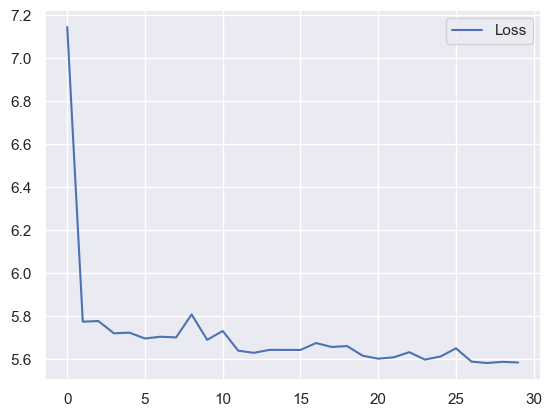

In [48]:
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [49]:
y_test_pre = model.predict(x_test)

2686/2686 [==============================] - 3s 1ms/step


In [50]:
pa=pd.DataFrame()
pa['Date']=X_test.reset_index().Date.iloc[1:-1]
pa['Prediction']=[i[0] for i in y_test_pre][1:] 
pa['Actual Values']=y_test[:-1]
pa.head()

,Date,Prediction,Actual Values
1,2020-05-02,0.000537,0.0
2,2020-05-03,0.000537,2.0
3,2020-05-04,0.000537,0.0
4,2020-05-05,1.482543,7.0
5,2020-05-06,8.736609,19.0


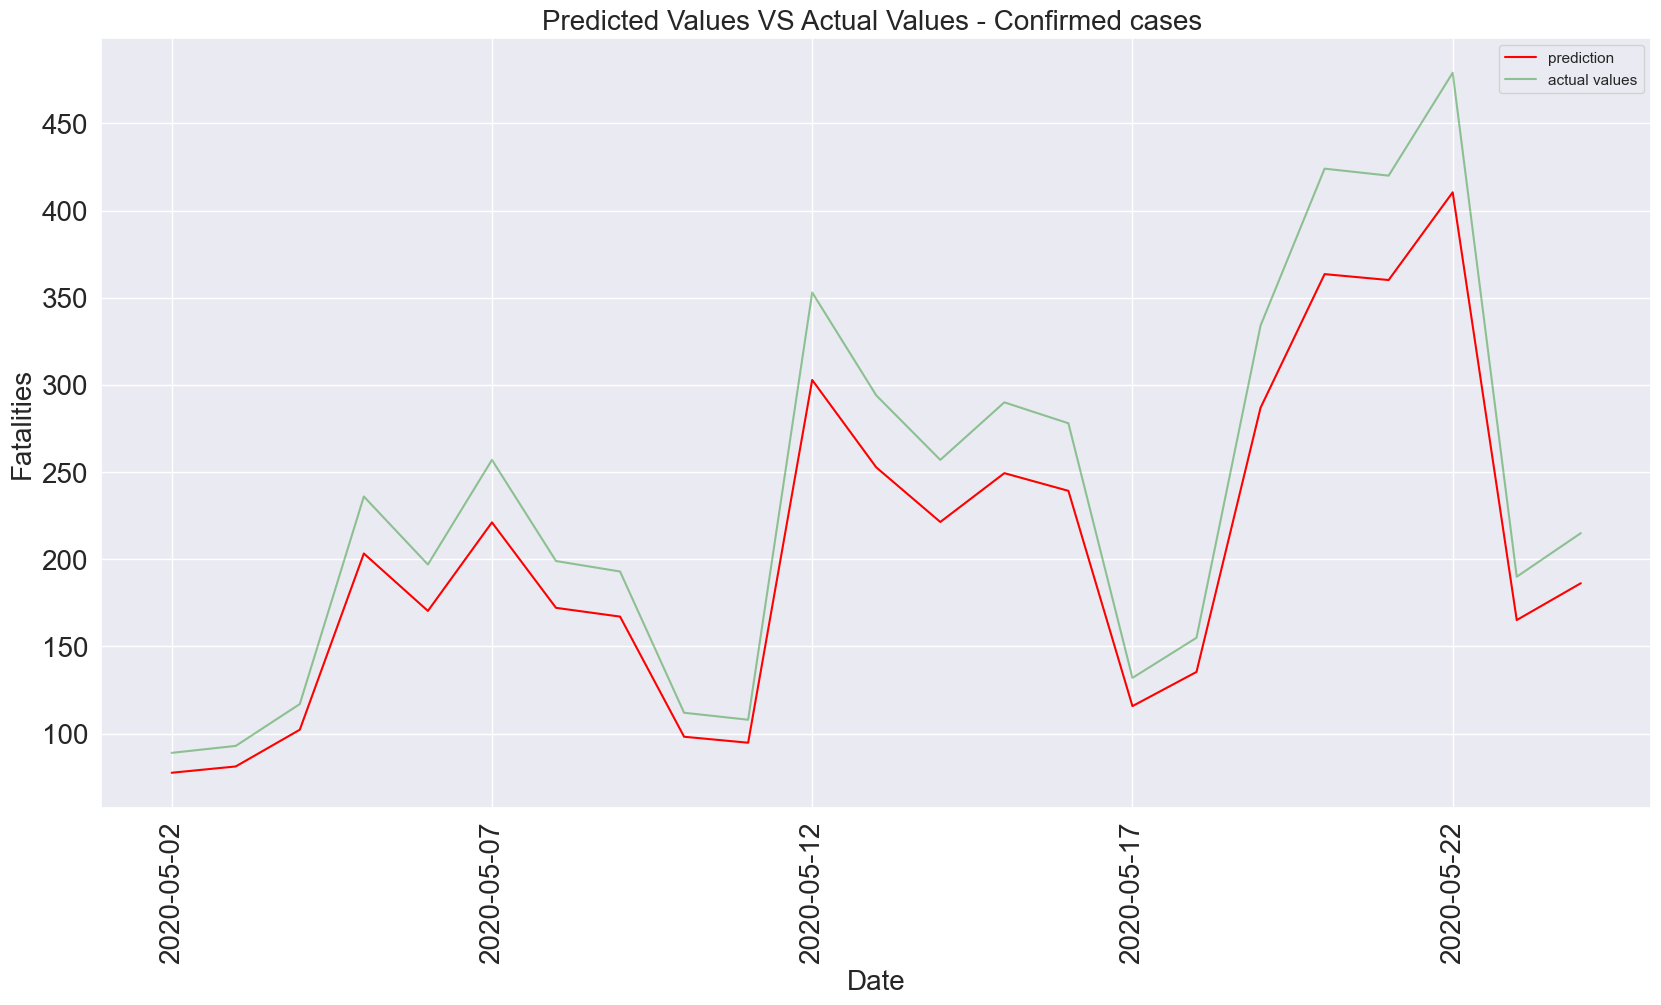

In [70]:
plt.figure(figsize=(20,10))
pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='green',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel('Fatalities',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Actual Values - Confirmed cases ',fontsize=20)
plt.legend()
plt.savefig('figures/Predicted Values VS Actual Values - Confirmed cases')

In [52]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse
print(RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:]))

53.01954720997893


### LSTM for top 10 countries

In [53]:
def normalization_train_test_split(country):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(country.drop(columns=['TargetValue','Country_Region','Date']))
    scaled_df=pd.DataFrame(data=scaled,columns=country.drop(columns=['TargetValue','Country_Region','Date']).columns)
    scaled_df['TargetValue']=list(country.TargetValue)
    X_train, X_test,Y_train,Y_test=train_test_split(scaled_df)
    train_data=pd.DataFrame()
    train_data[X_train.columns]=X_train
    train_data['TargetValues']=Y_train
    test_data=pd.DataFrame()
    test_data[X_test.columns]=X_test
    test_data['TargetValues']=Y_test

    x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)
    return x_train, x_test,y_train,y_test

2479/2479 [==============================] - 3s 1ms/step
US - RMSE: 105.2298986257866
1/1 [==============================] - 0s 134ms/step
Brazil - RMSE: 1023.5027501816974
1/1 [==============================] - 0s 140ms/step
Russia - RMSE: 67.25861563521376
9/9 [==============================] - 0s 1ms/step
United Kingdom - RMSE: 1575.9142990070357
1/1 [==============================] - 0s 135ms/step
Spain - RMSE: 93.67900767111088
1/1 [==============================] - 0s 132ms/step
Italy - RMSE: 33.69400217064151
9/9 [==============================] - 0s 1ms/step
France - RMSE: 1707.3272651259304
1/1 [==============================] - 0s 140ms/step
Germany - RMSE: 45.90797997080794
11/11 [==============================] - 0s 1ms/step
Canada - RMSE: 38.6924086726072
27/27 [==============================] - 0s 1ms/step
China - RMSE: 246.0820014838514
1/1 [==============================] - 0s 138ms/step
Turkey - RMSE: 6.705656097490913


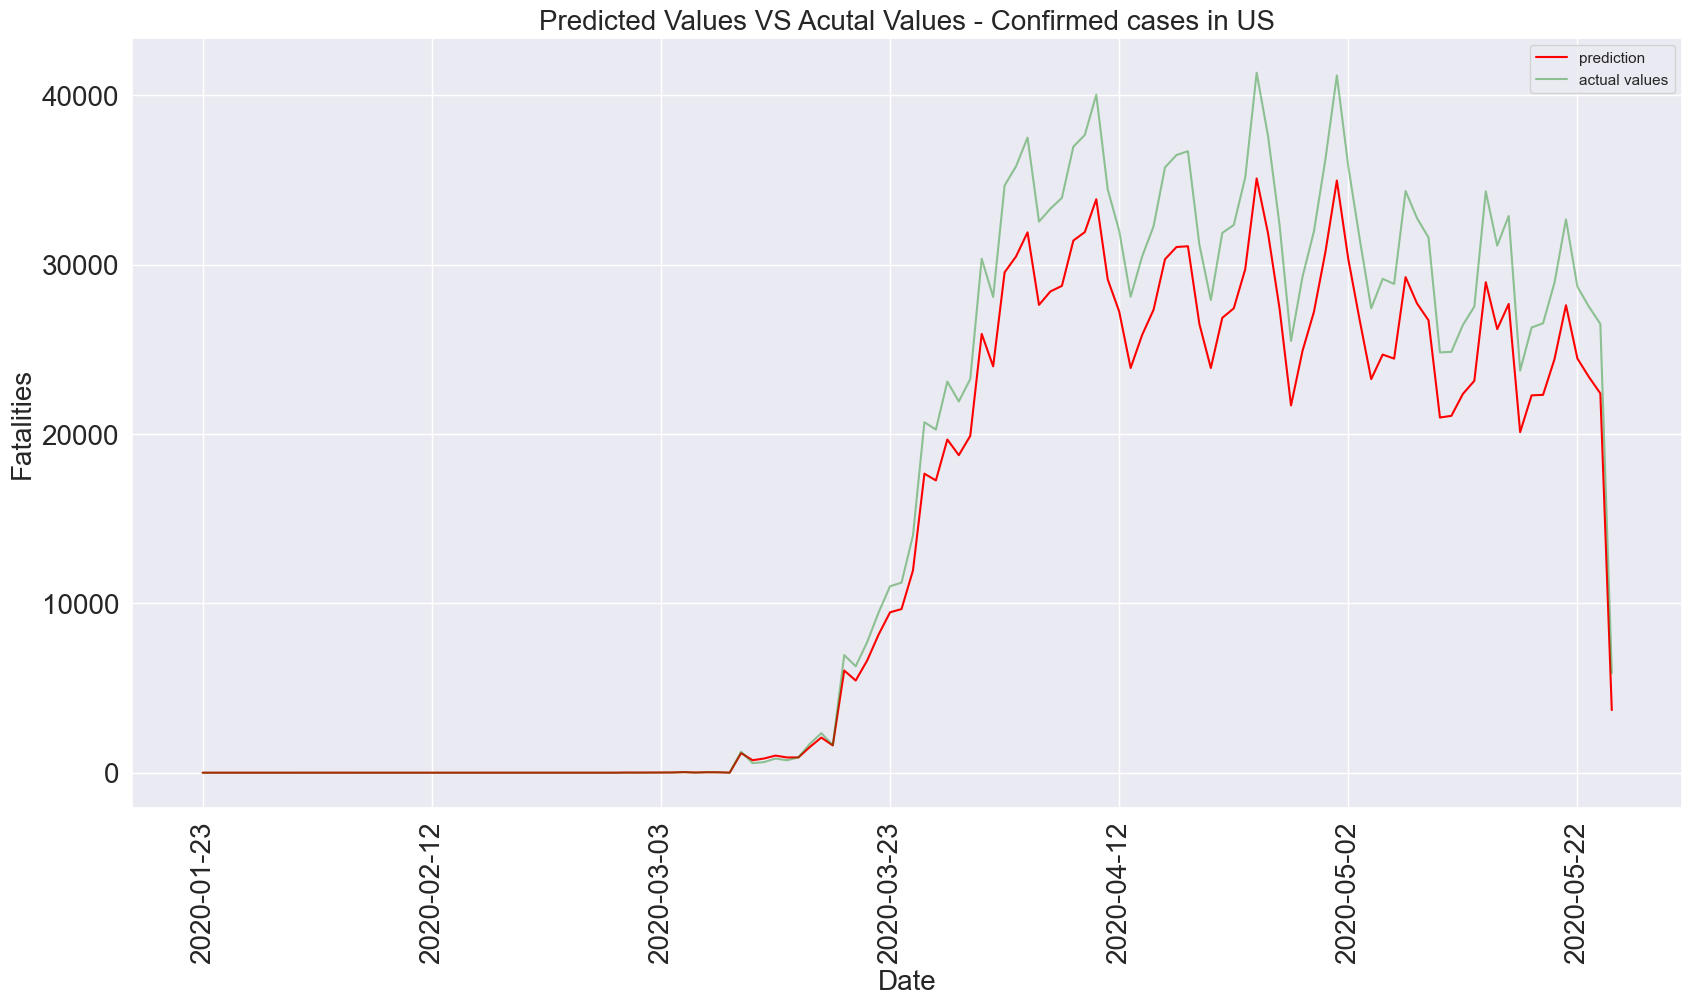

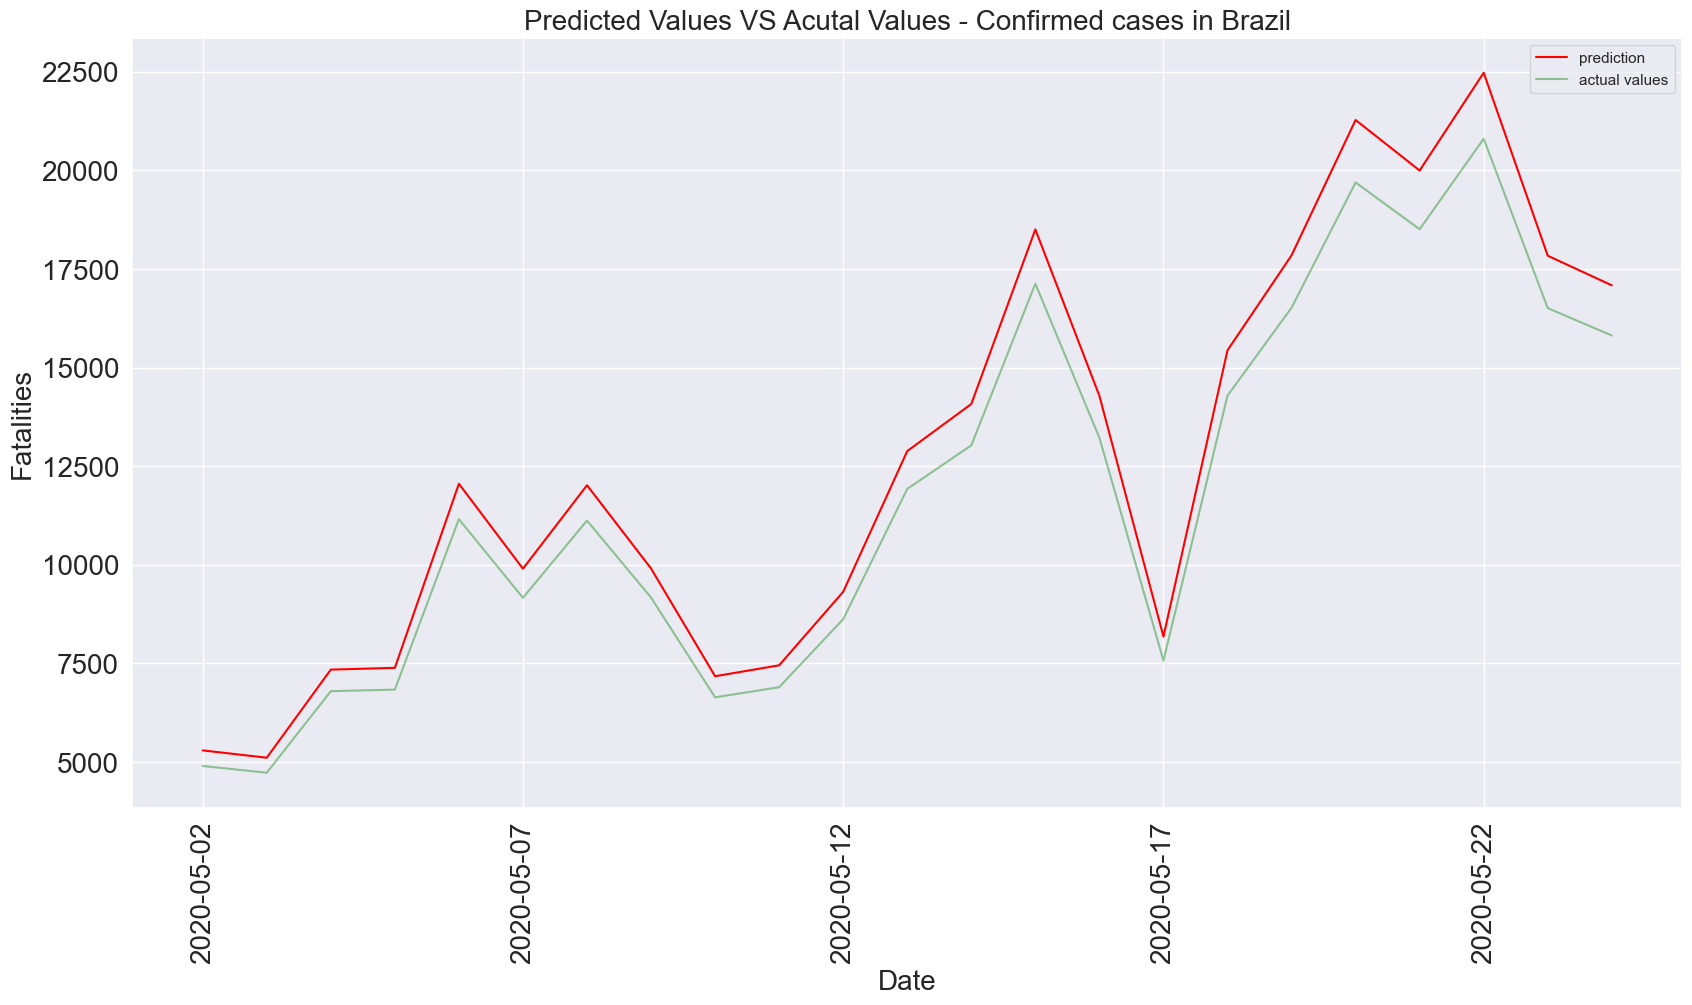

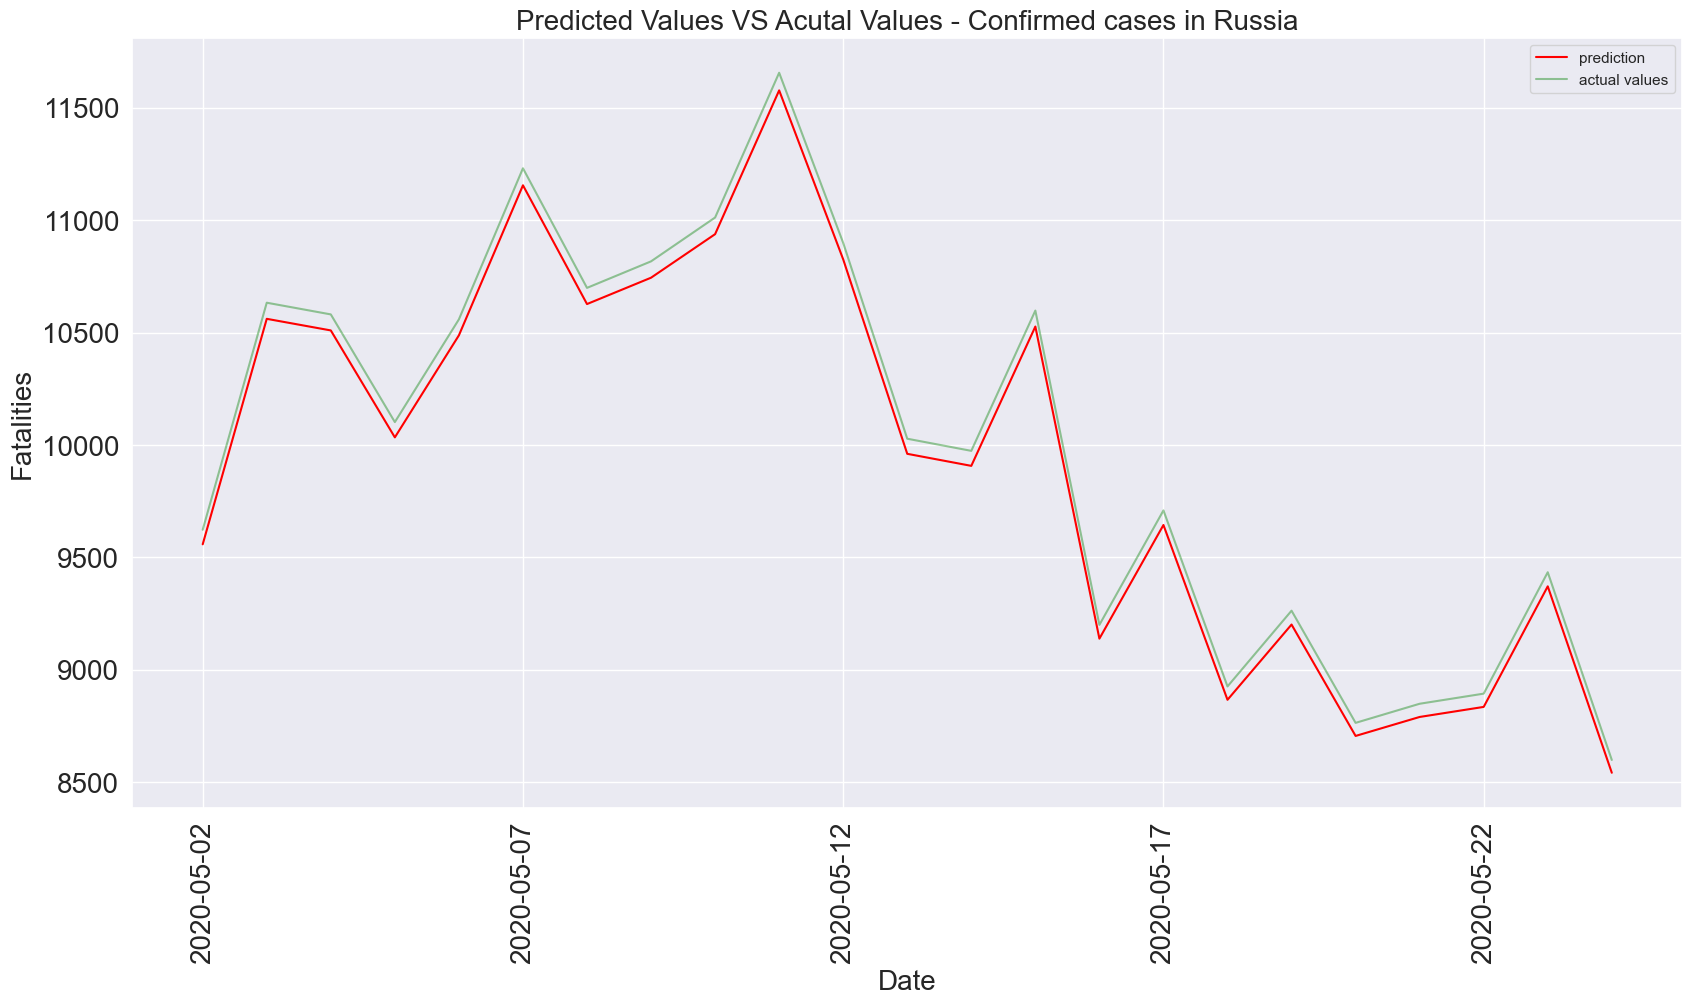

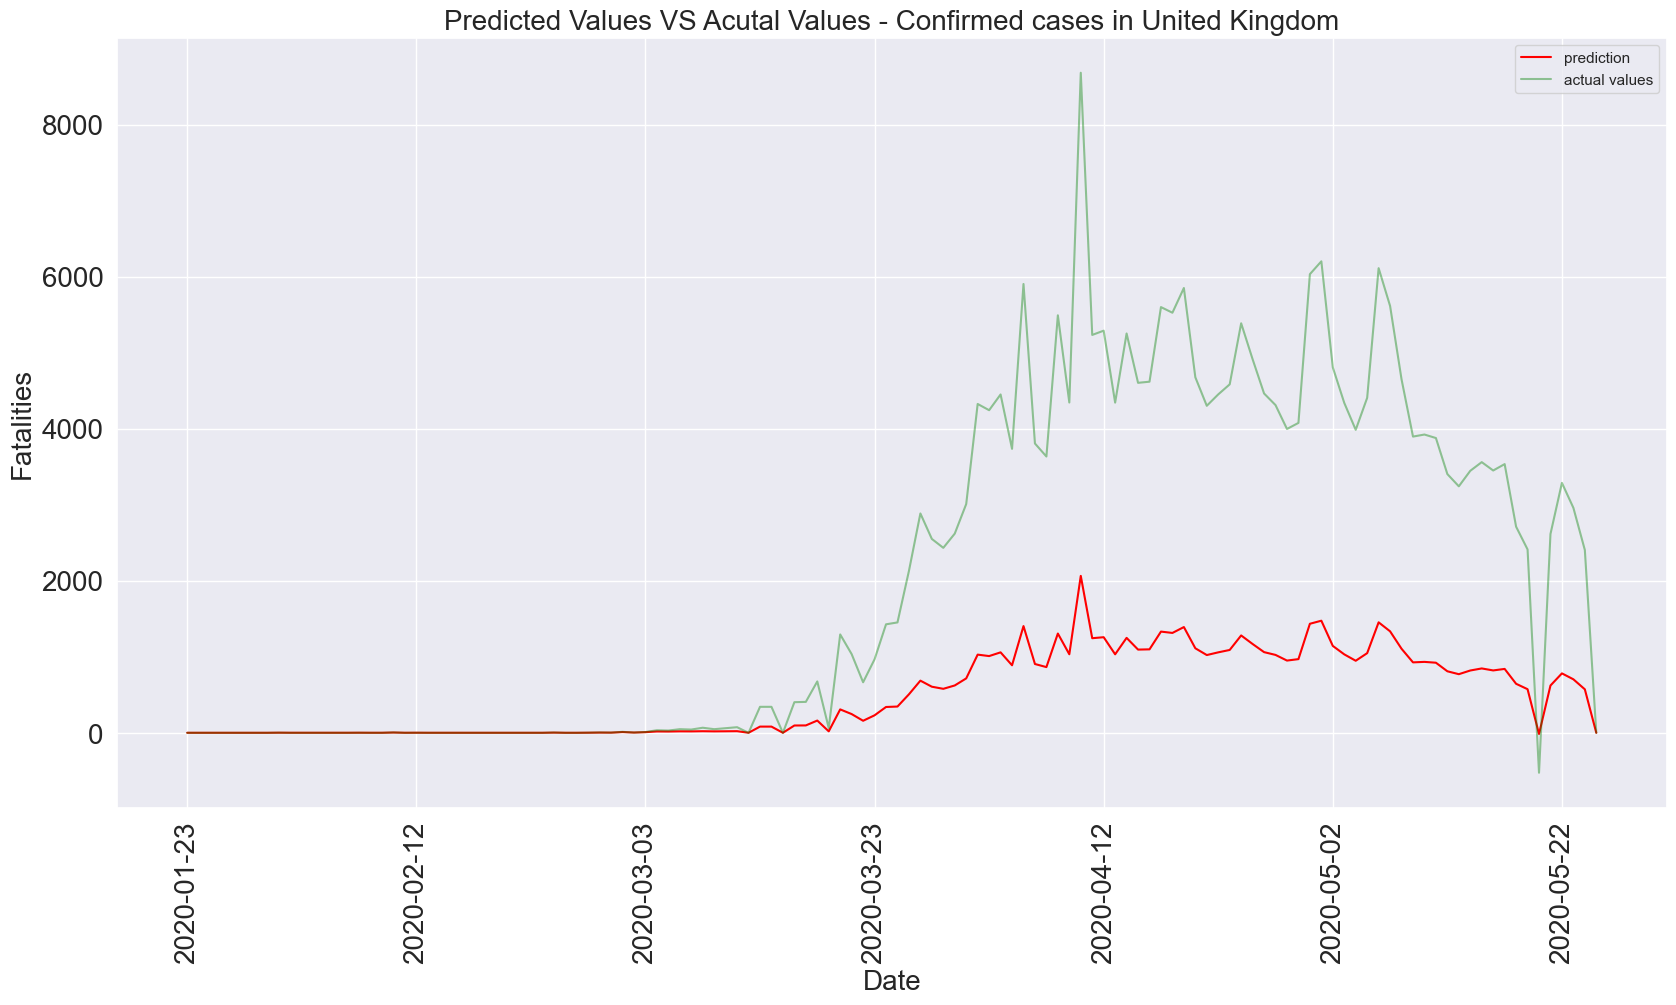

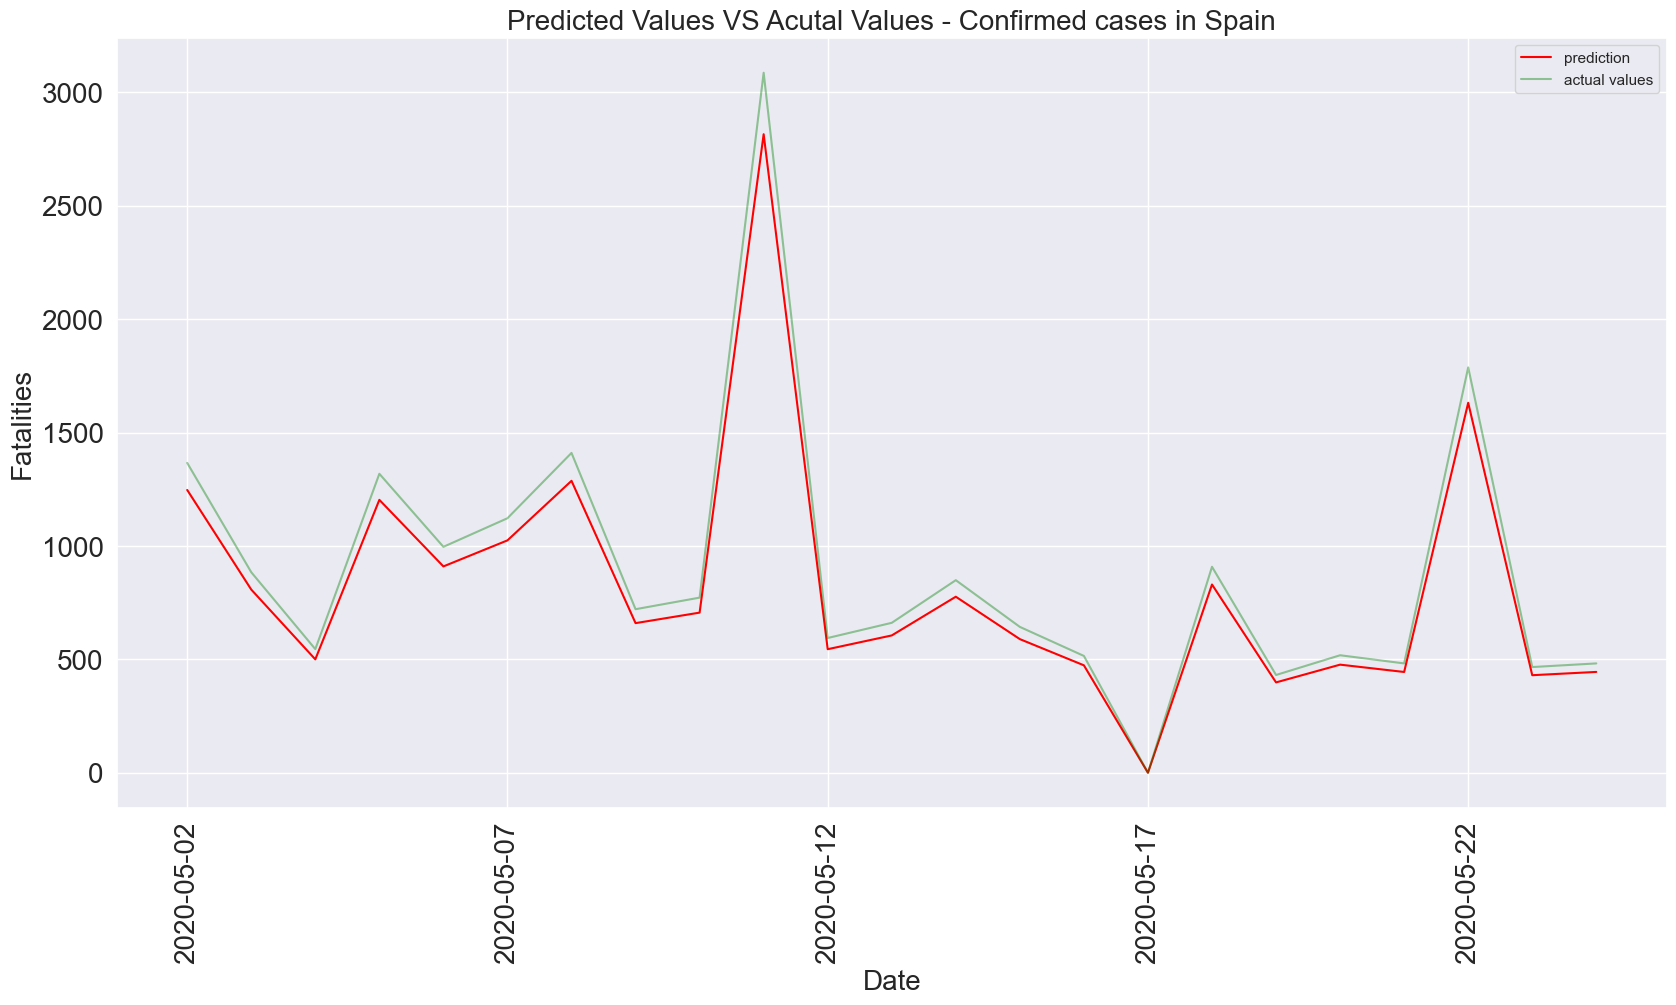

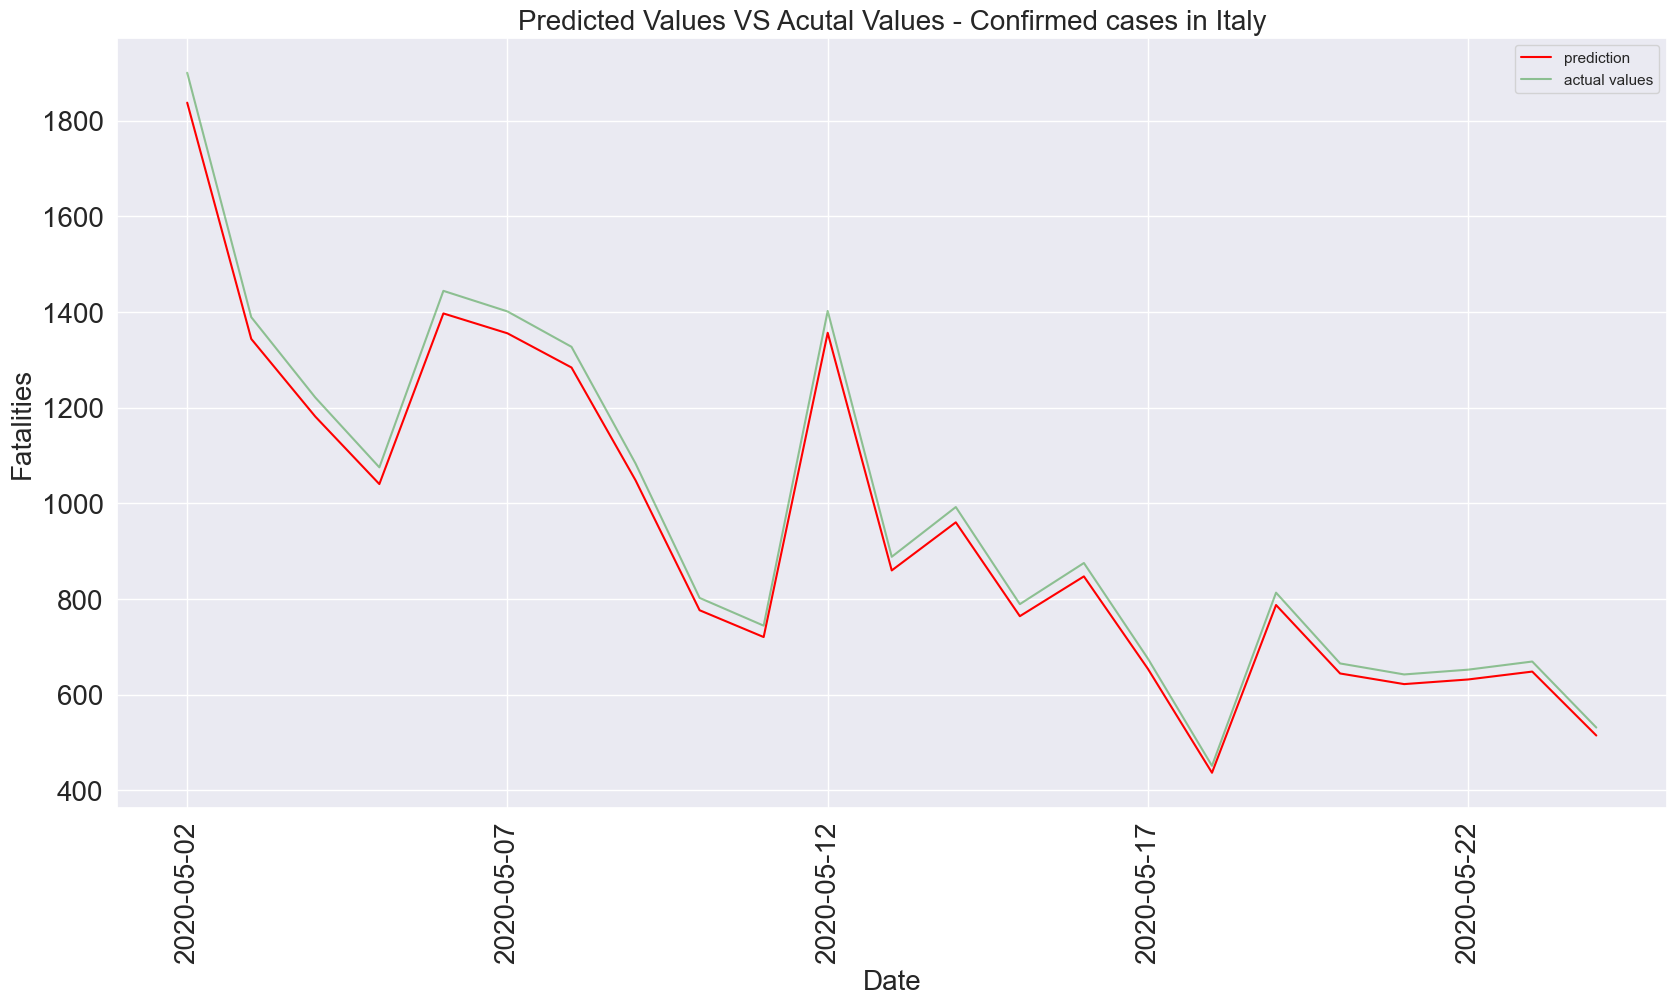

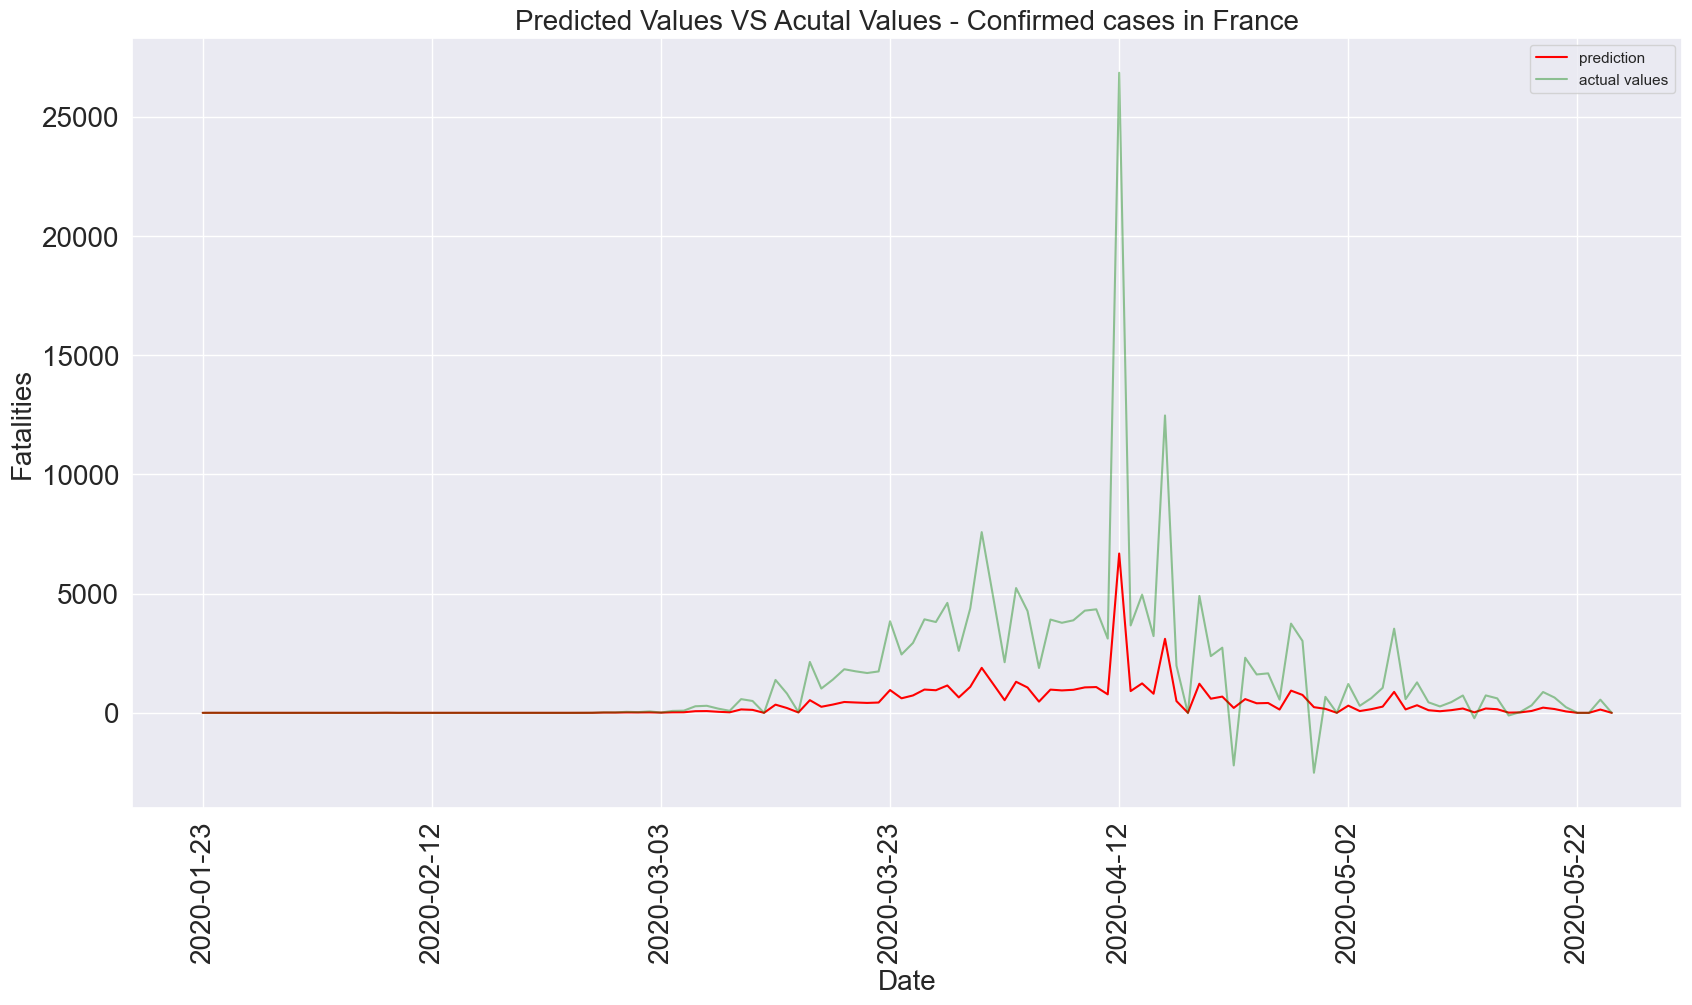

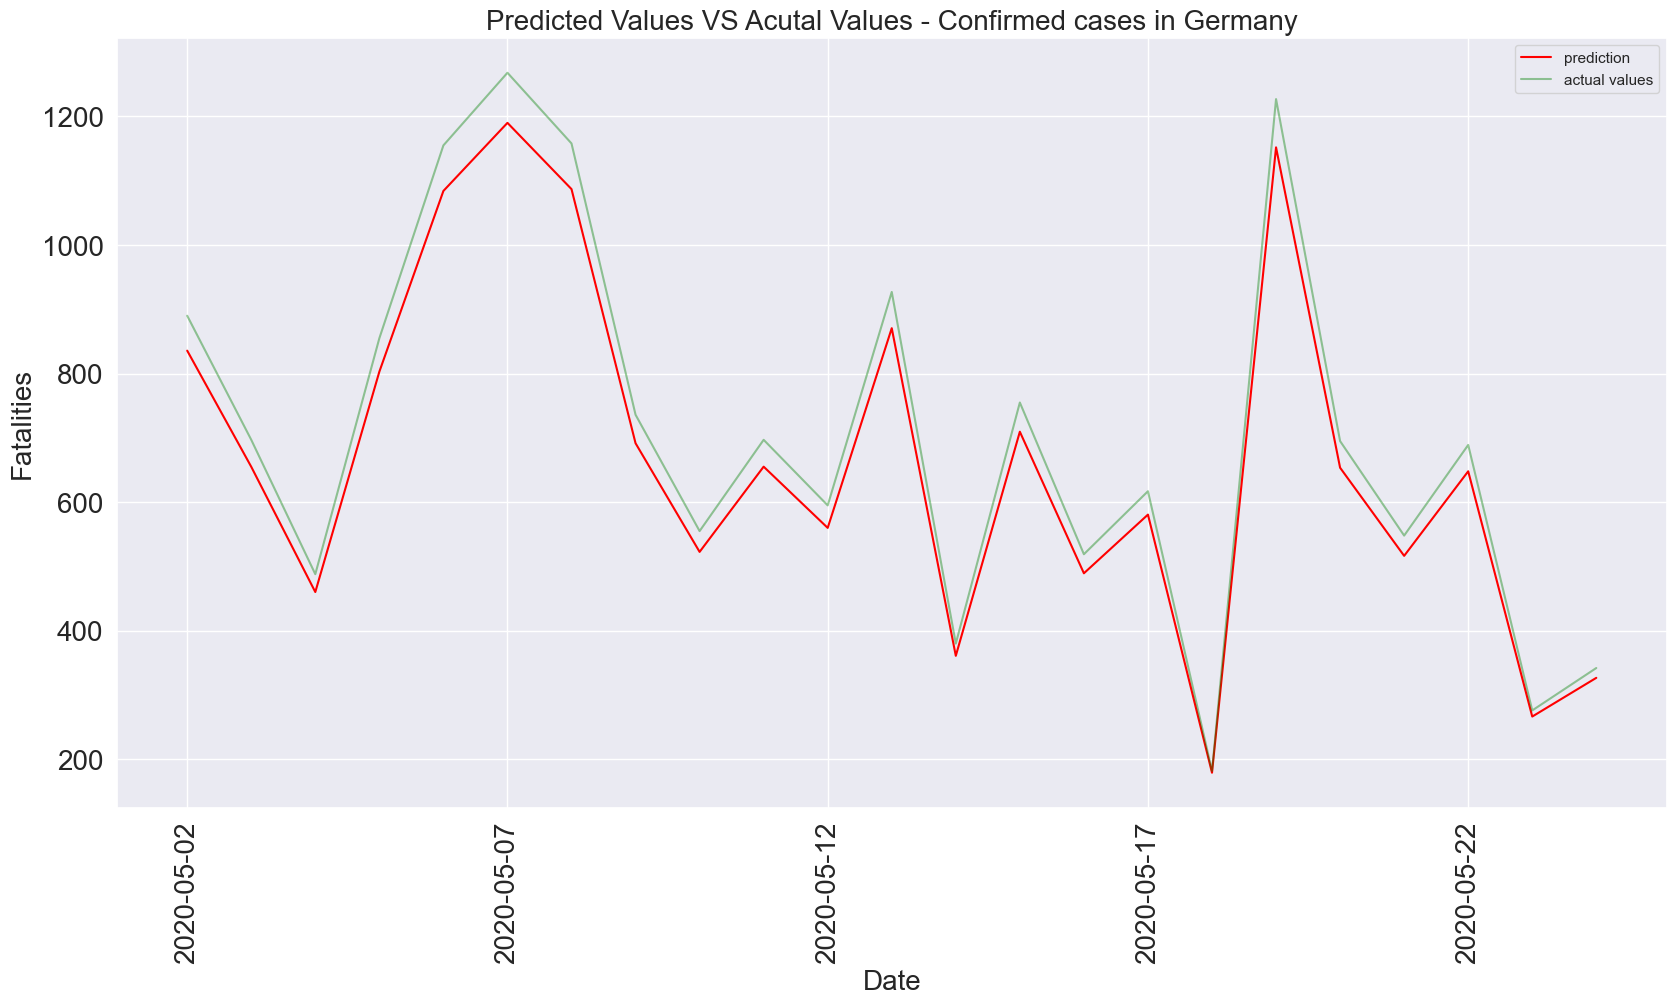

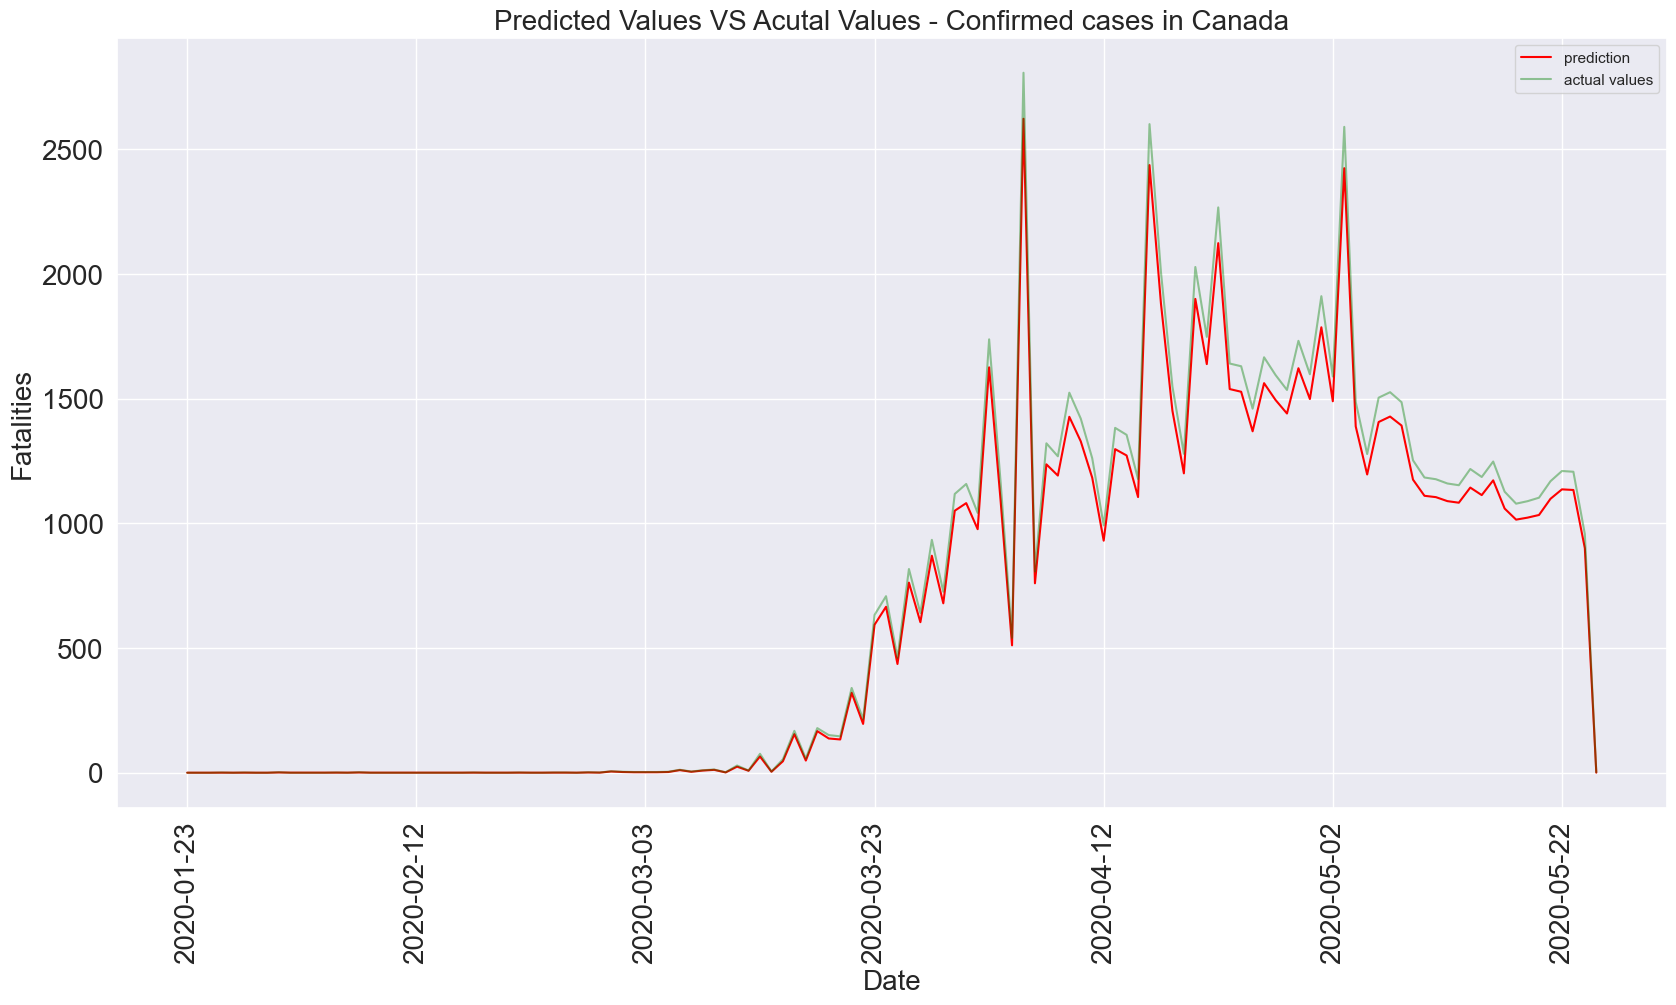

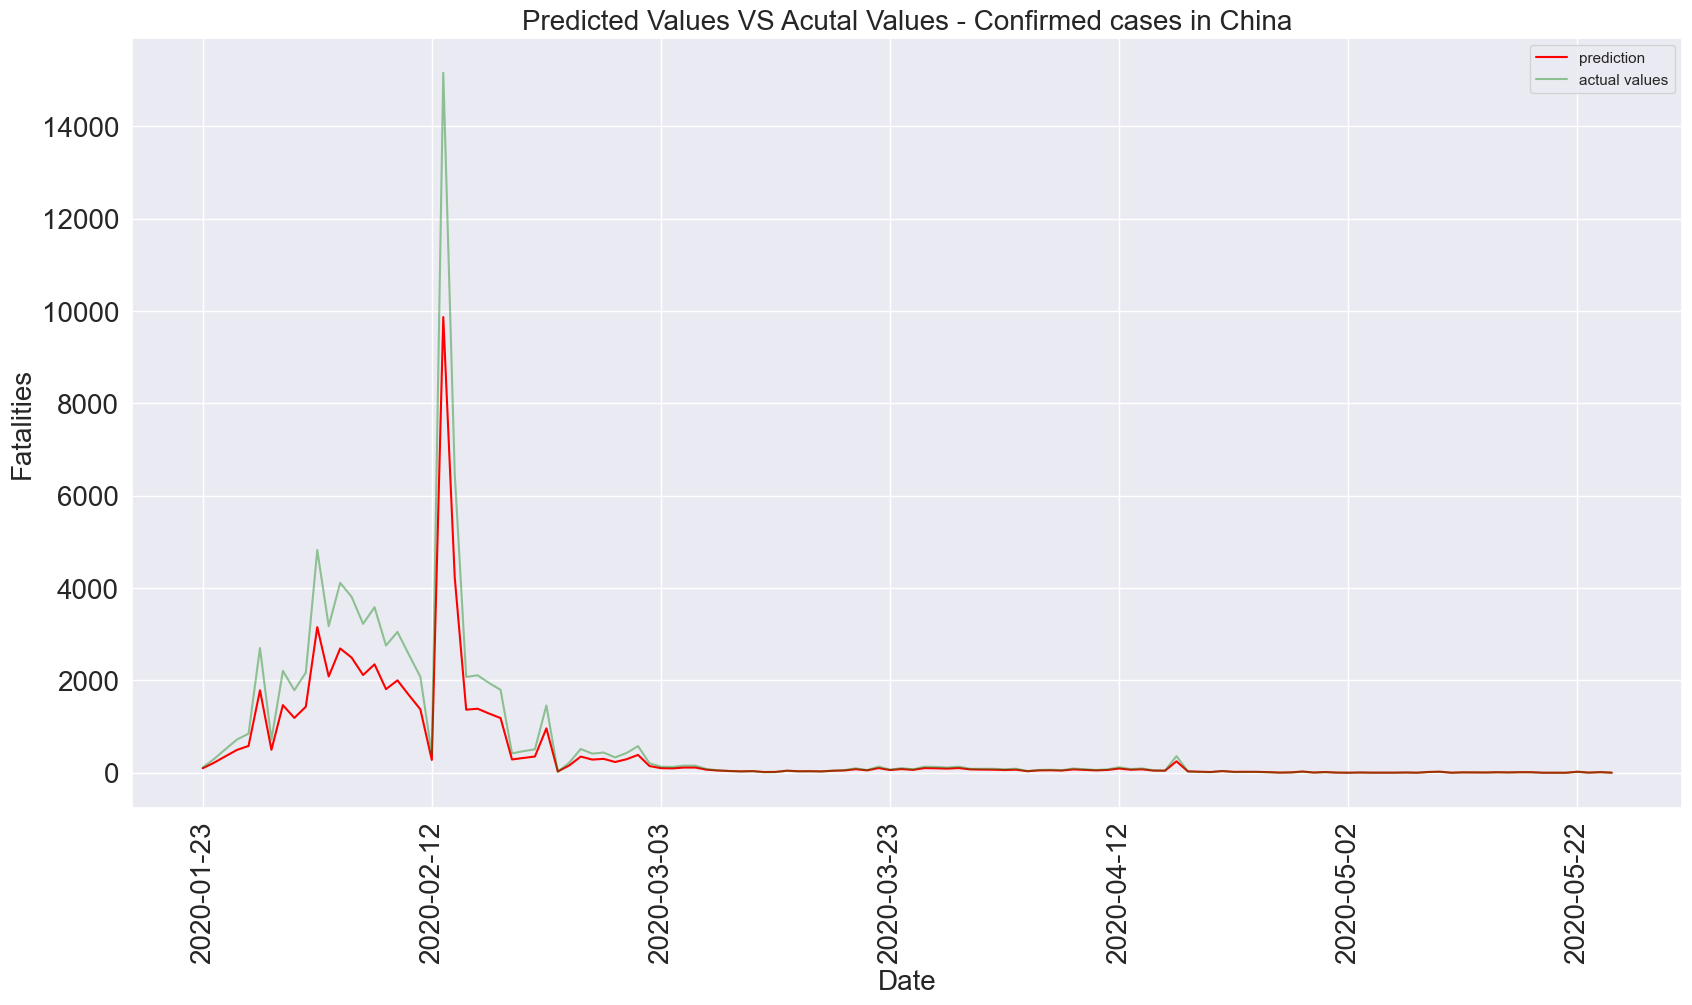

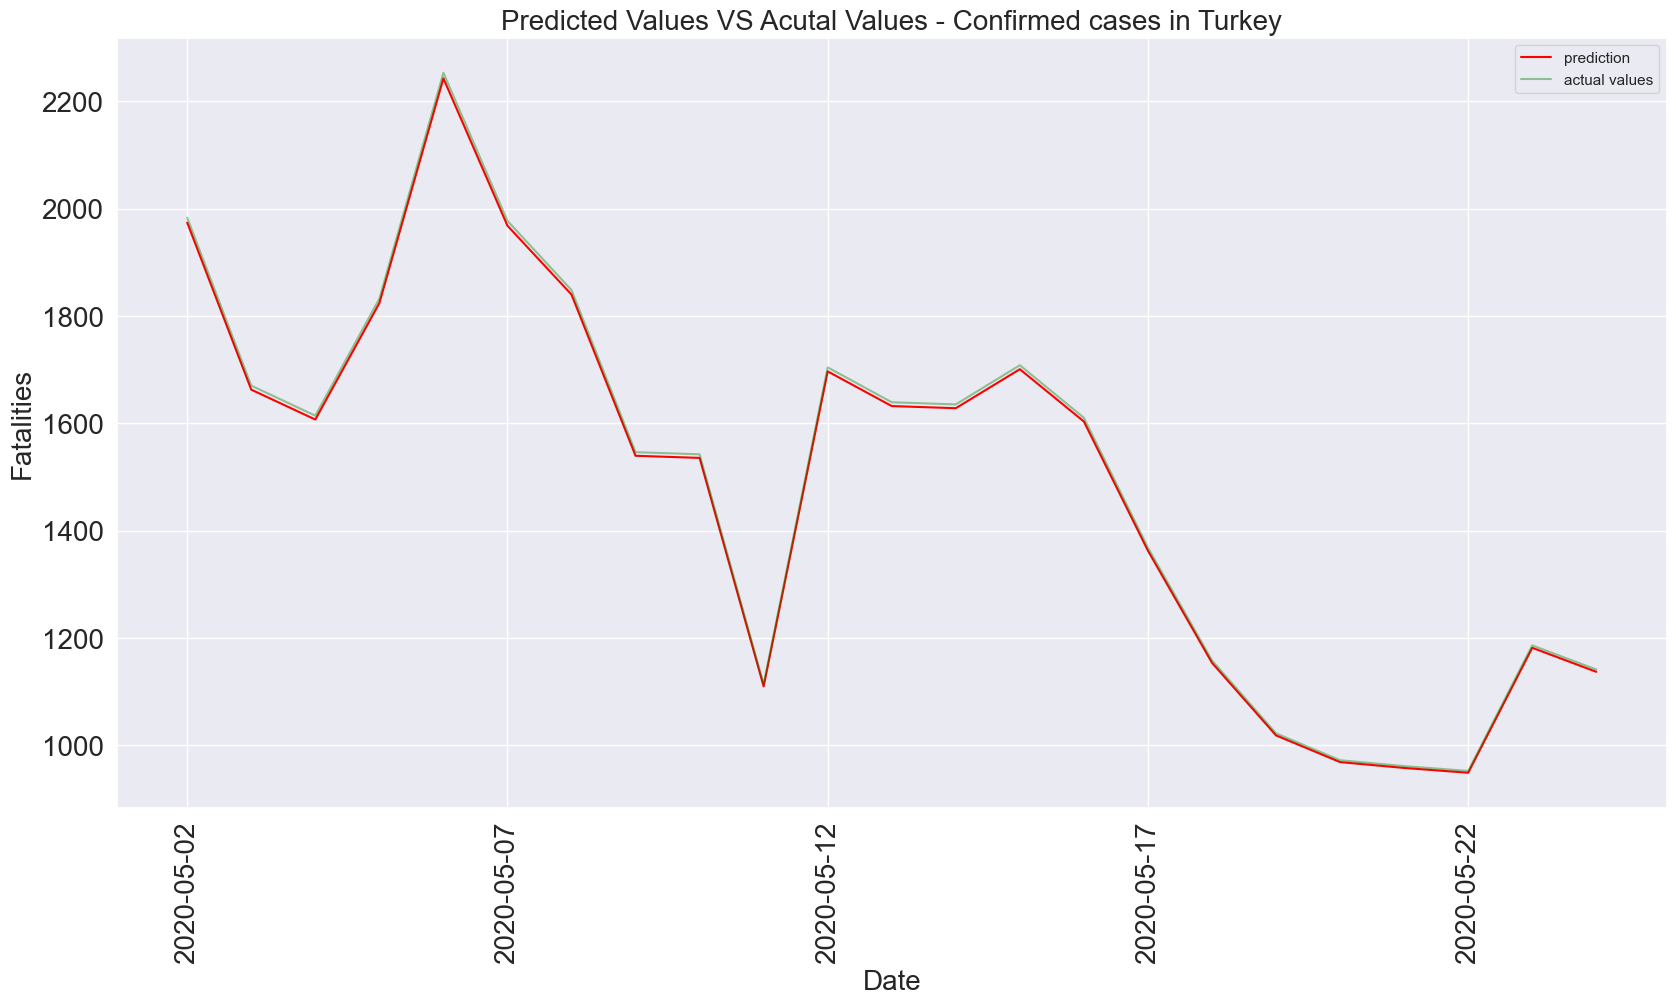

In [54]:
for i in range(len(top_10_country_names)): 
    country=confirm[confirm.Country_Region==top_10_country_names[i]]
    x_train, x_test,y_train,y_test=normalization_train_test_split(country)
    model = Sequential()
    model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(x_train, y_train, epochs=50, batch_size=30,  verbose=0, shuffle=False)
    y_test_pre=model.predict(x_test)
    print('{} - RMSE: {}'.format(top_10_country_names[i],RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:])))
    pa=pd.DataFrame()
    pa['Date']=list(country.Date.iloc[int(len(country)*0.8):])[1:-1]
    pa['Prediction']=[i[0] for i in y_test_pre][1:] 
    pa['Actual Values']=list(y_test[:-1])

    plt.figure(figsize=(20,10))
    pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
    pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='green',alpha=0.4)
    plt.xticks(rotation=90,size=20)
    plt.yticks(size=20)

    plt.ylabel('Fatalities',fontsize=20)
    plt.xlabel('Date',fontsize=20)
    plt.title('Predicted Values VS Acutal Values - Confirmed cases in {}'.format(top_10_country_names[i]),fontsize=20)
    plt.legend()

## Lets us use this model for Fatalities

In [55]:
fatality=df[df.Target=='Fatalities'].drop(columns='Target')
top_10_countries=pd.DataFrame(fatality.groupby('Country_Region')['TargetValue'].sum()).sort_values(by='TargetValue',ascending=False).reset_index()
top_10_country_names=top_10_countries.Country_Region[:11]

In [56]:
scaled = scaler.fit_transform(fatality.drop(columns=['TargetValue','Country_Region','Date']))
scaled_df=pd.DataFrame(data=scaled,columns=fatality.drop(columns=['TargetValue','Country_Region','Date']).columns)

In [57]:
fa=fatality.copy()
fa[scaled_df.columns]=np.array(scaled_df)
fa['country']=list(fa.Country_Region)

In [58]:
fa=fa.set_index(['Country_Region','Date'])
fa.head()

month       day  Population  Weight  TargetValue  \
Country_Region Date                                                           
Afghanistan    2020-01-23    0.0  0.733333    0.019815  0.0616          0.0   
               2020-01-24    0.0  0.766667    0.019815  0.0616          0.0   
               2020-01-25    0.0  0.800000    0.019815  0.0616          0.0   
               2020-01-26    0.0  0.833333    0.019815  0.0616          0.0   
               2020-01-27    0.0  0.866667    0.019815  0.0616          0.0   

                               country  
Country_Region Date                     
Afghanistan    2020-01-23  Afghanistan  
               2020-01-24  Afghanistan  
               2020-01-25  Afghanistan  
               2020-01-26  Afghanistan  
               2020-01-27  Afghanistan

### Train Test Split

In [59]:
country=list(set(fa.country))
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=fa[fa['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split(data)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [60]:
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

### Data Preprocessing

In [61]:
encoder = LabelEncoder()
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])
test_data.shape

(85922, 6)

In [62]:
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

### Model

In [63]:
model = Sequential()
model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(x_train, y_train, epochs=30, batch_size=50, verbose=0, shuffle=False)

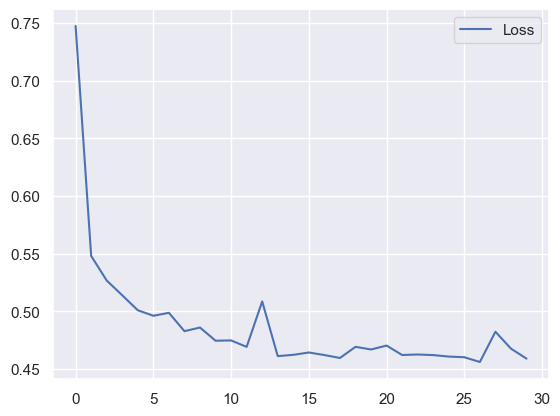

In [64]:
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [65]:
y_test_pre=model.predict(x_test)

2686/2686 [==============================] - 3s 1ms/step


### Evaluation of Metrics

In [66]:
pa=pd.DataFrame()
pa['Date']=X_test.reset_index().Date.iloc[1:-1]
pa['Prediction']=[i[0] for i in y_test_pre][1:] 
pa['Actual Values']=y_test[:-1]
pa.head()

,Date,Prediction,Actual Values
1,2020-05-02,0.000028,0.0
2,2020-05-03,0.000028,0.0
3,2020-05-04,0.000028,0.0
4,2020-05-05,0.000028,0.0
5,2020-05-06,0.000028,0.0


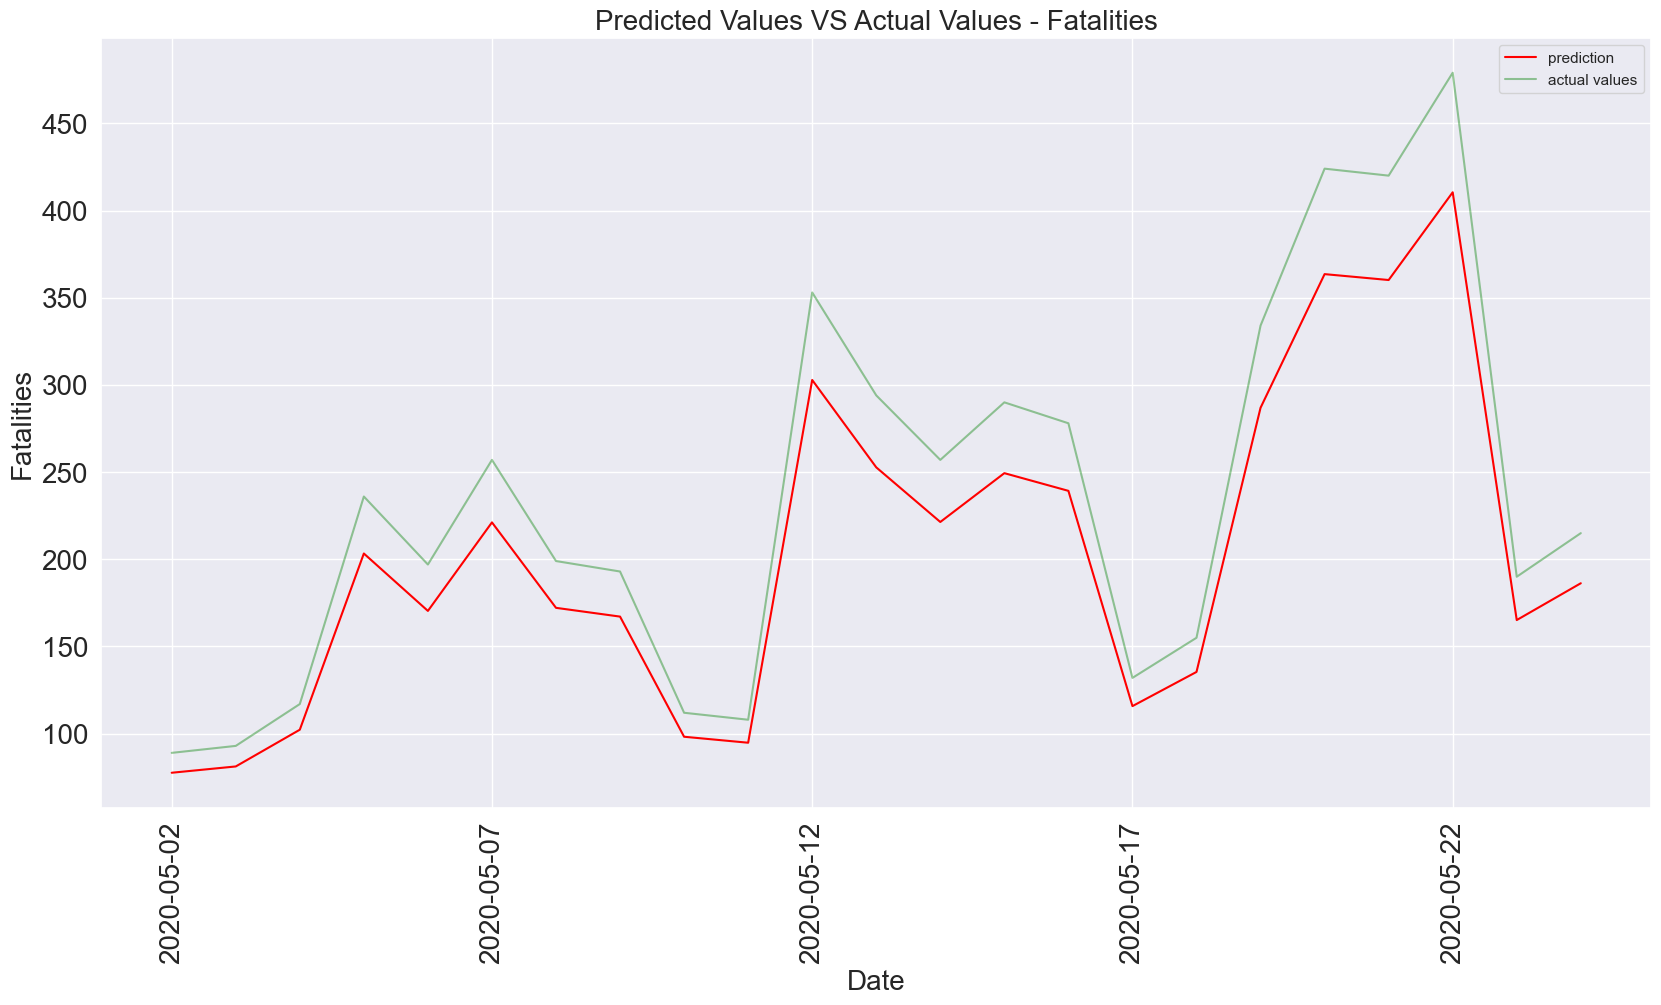

In [71]:
plt.figure(figsize=(20,10))
pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='green',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel('Fatalities',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Actual Values - Fatalities',fontsize=20)
plt.legend()
plt.savefig('Predicted Values VS Actual Values - Fatalities')

In [68]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse
print(RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:]))

13.53538059759609


### LSTM for top 10 countries

2479/2479 [==============================] - 3s 1ms/step
US - RMSE: 6.266188102359702
9/9 [==============================] - 0s 1ms/step
United Kingdom - RMSE: 161.85410904063107
1/1 [==============================] - 0s 133ms/step
Italy - RMSE: 8.272671118905764
9/9 [==============================] - 0s 1ms/step
France - RMSE: 267.97604492142904
1/1 [==============================] - 0s 135ms/step
Spain - RMSE: 7.25684263128484
1/1 [==============================] - 0s 137ms/step
Brazil - RMSE: 57.46169227561459
11/11 [==============================] - 0s 1ms/step
Canada - RMSE: 12.032369395924928
1/1 [==============================] - 0s 137ms/step
Belgium - RMSE: 16.36244487792181
27/27 [==============================] - 0s 1ms/step
China - RMSE: 31.811795480248428
1/1 [==============================] - 0s 136ms/step
Germany - RMSE: 21.48541977253918
1/1 [==============================] - 0s 141ms/step
Mexico - RMSE: 36.22454790564729


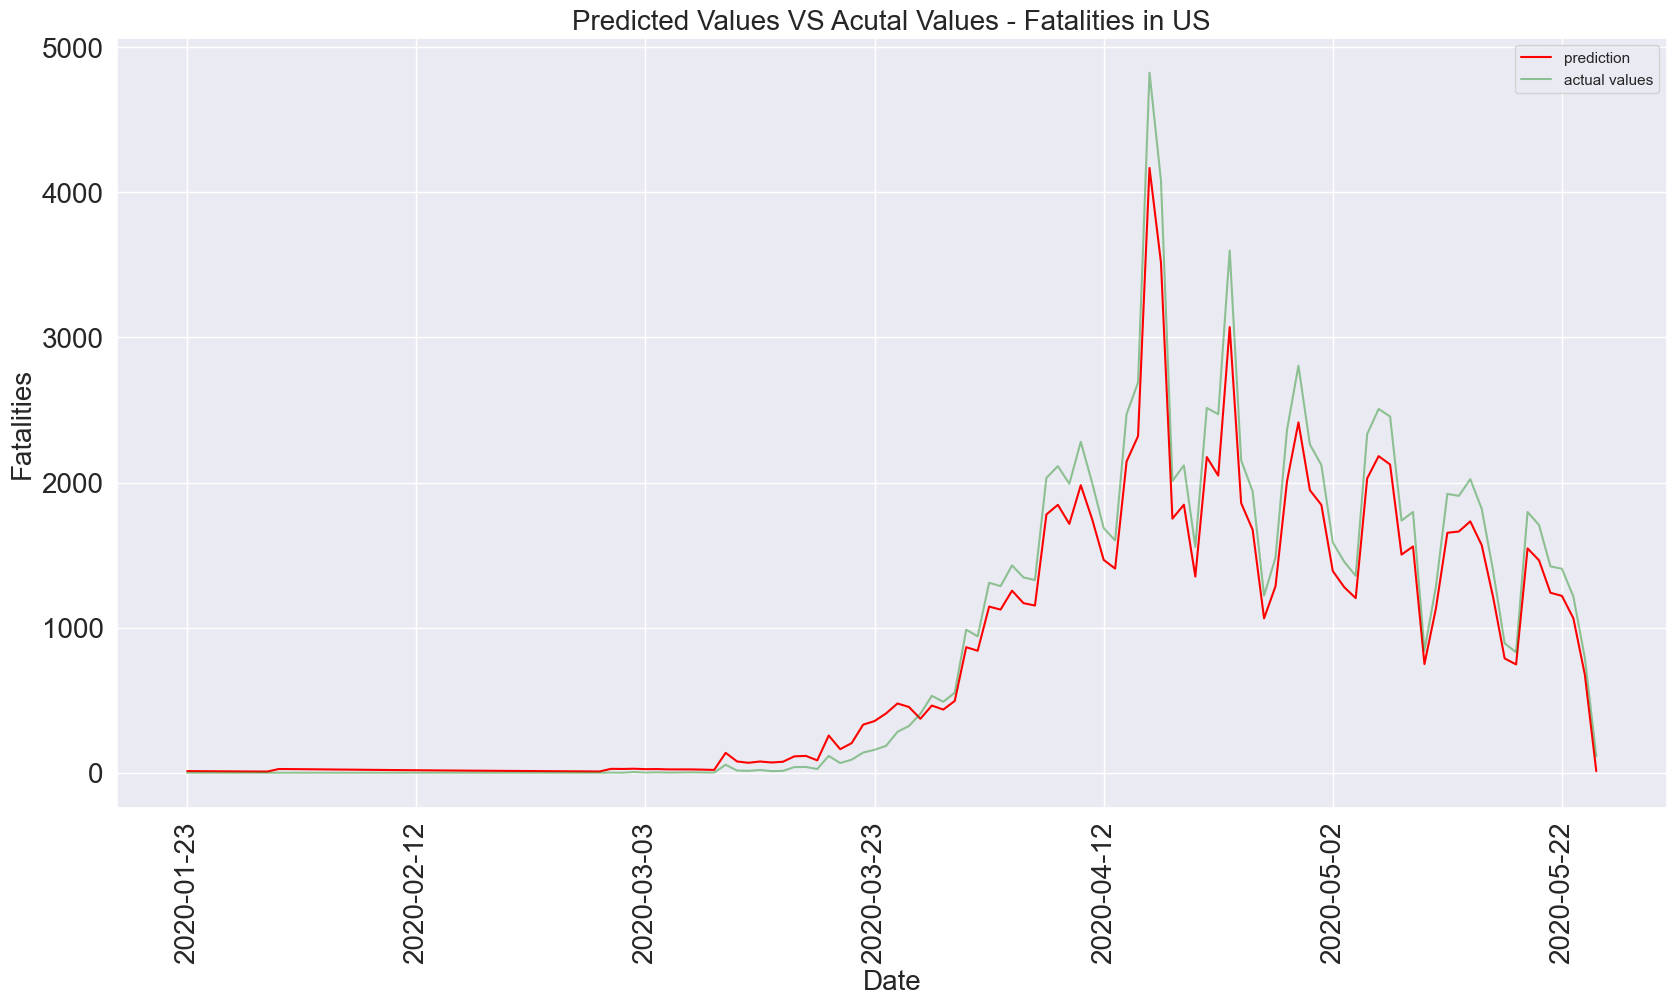

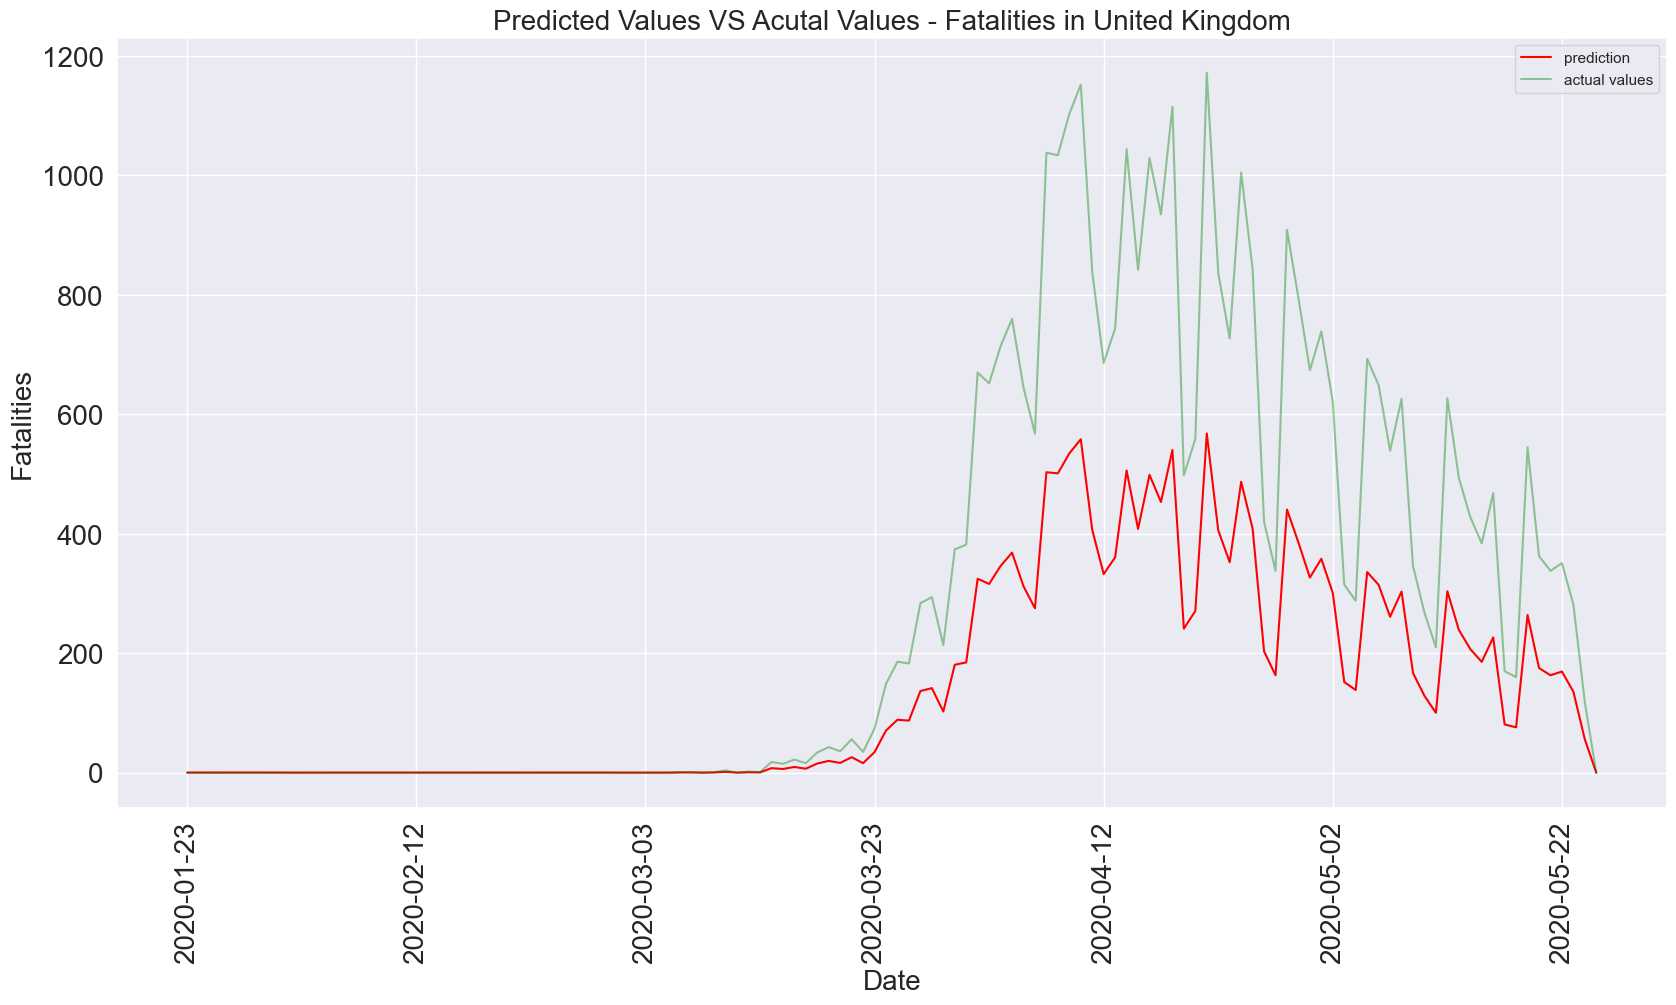

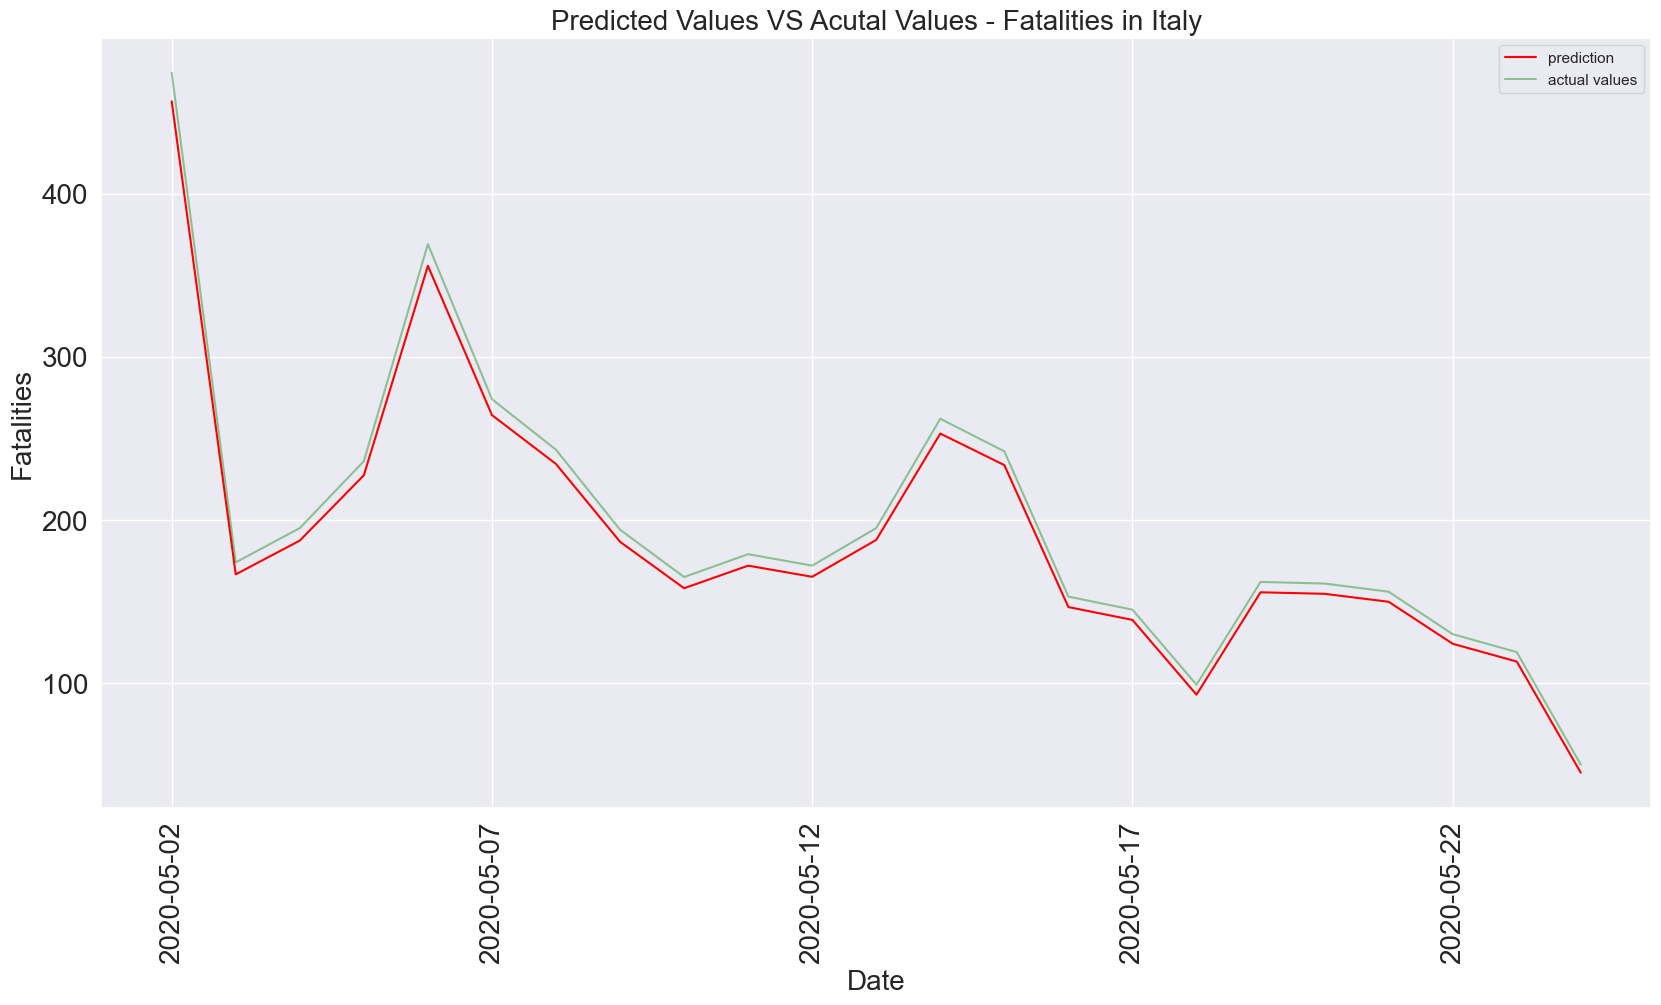

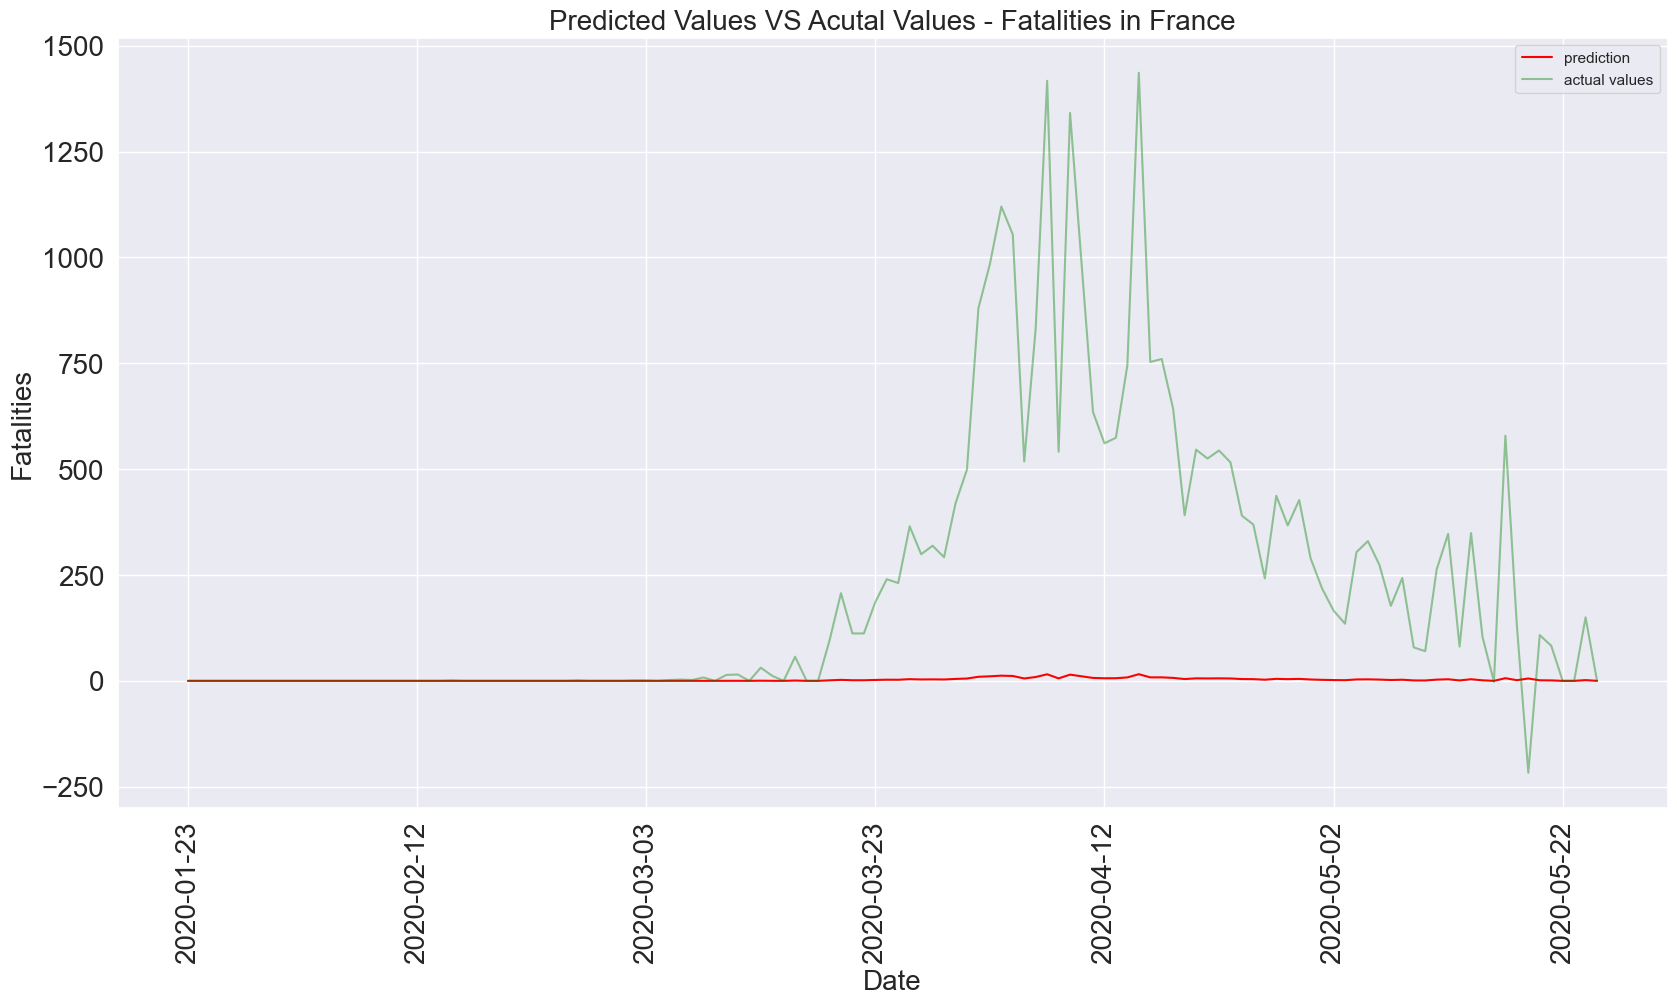

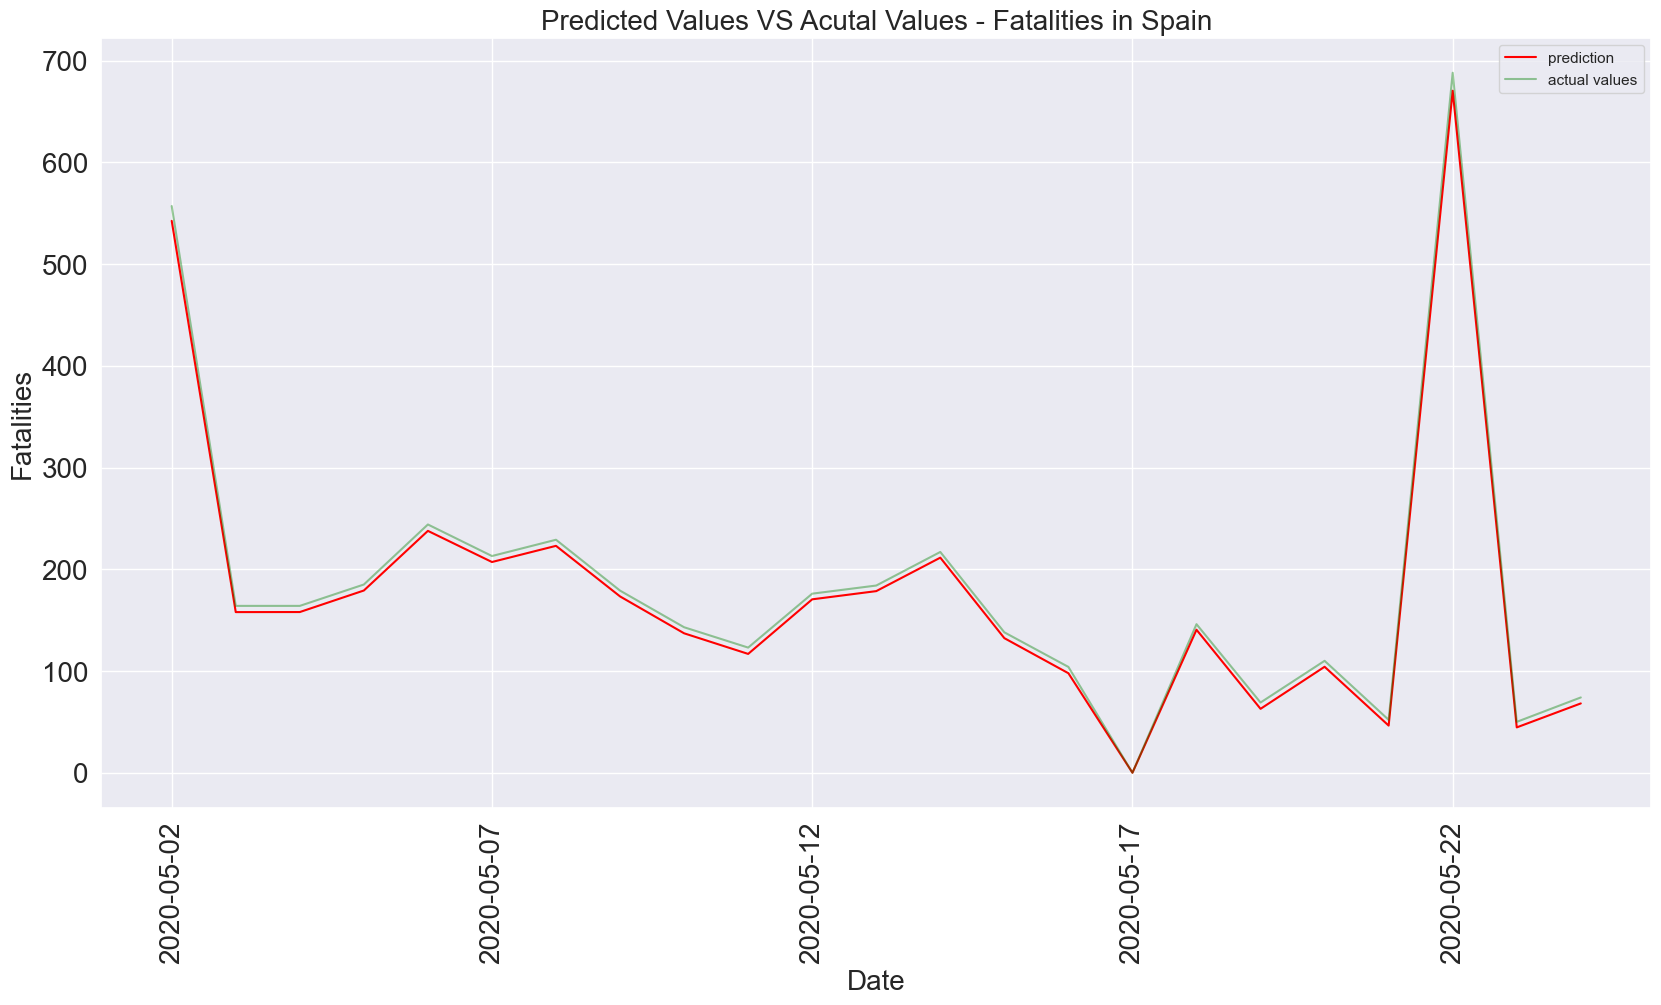

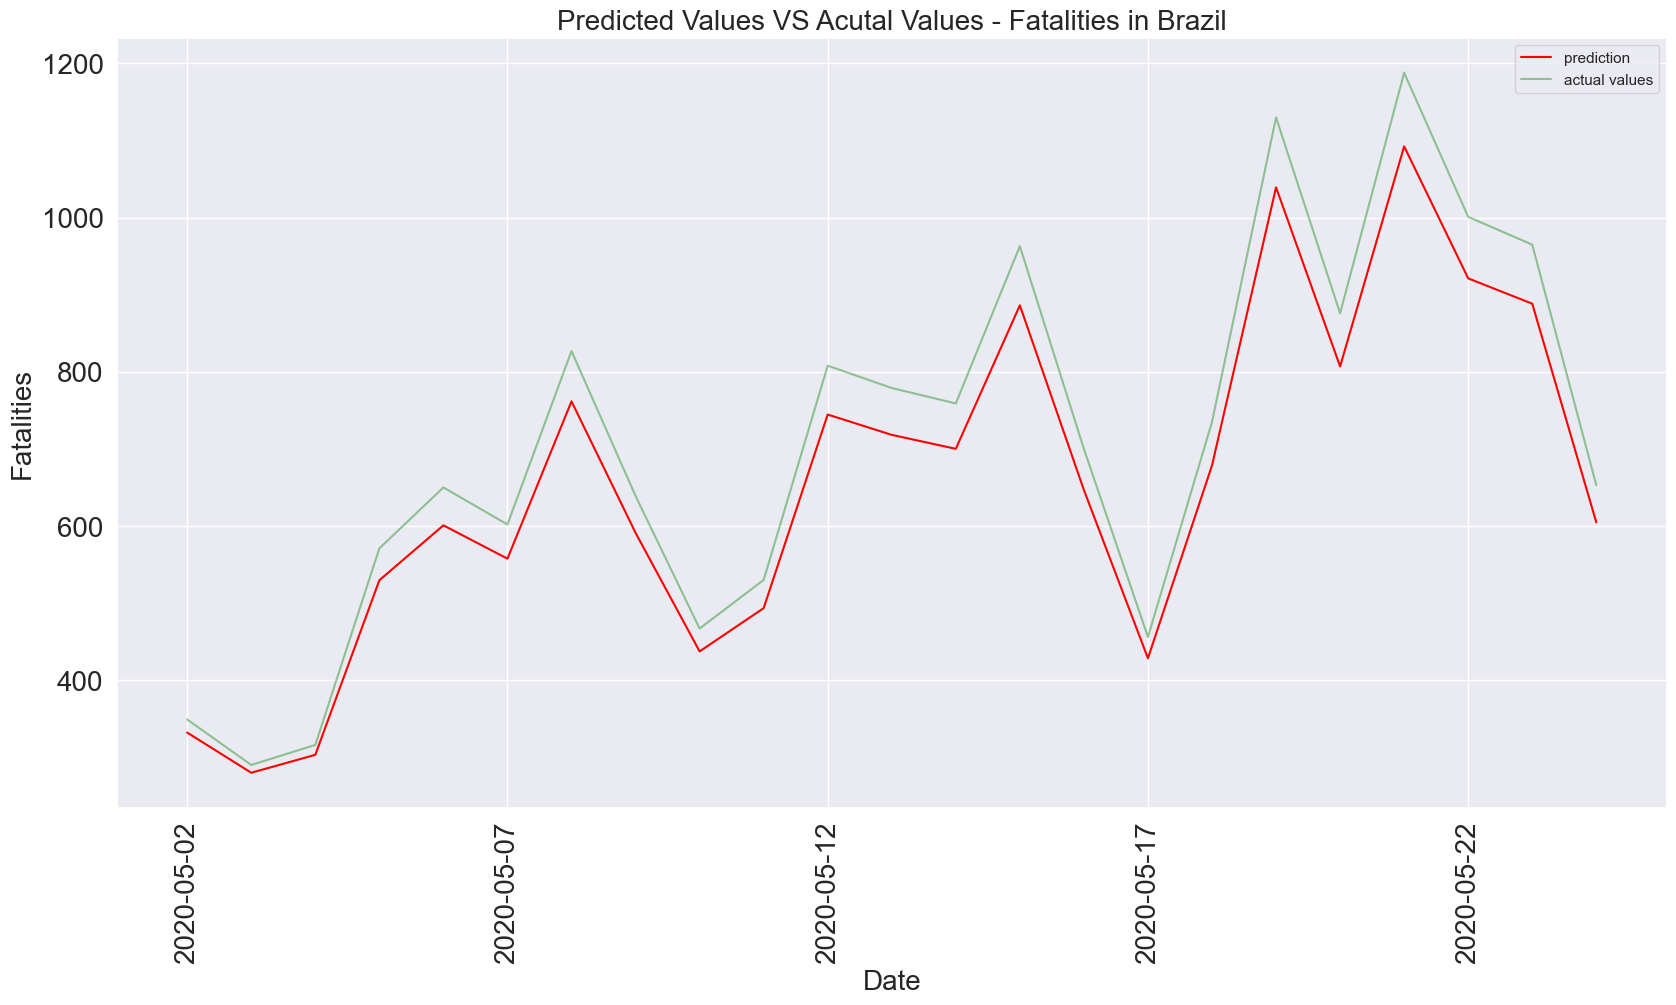

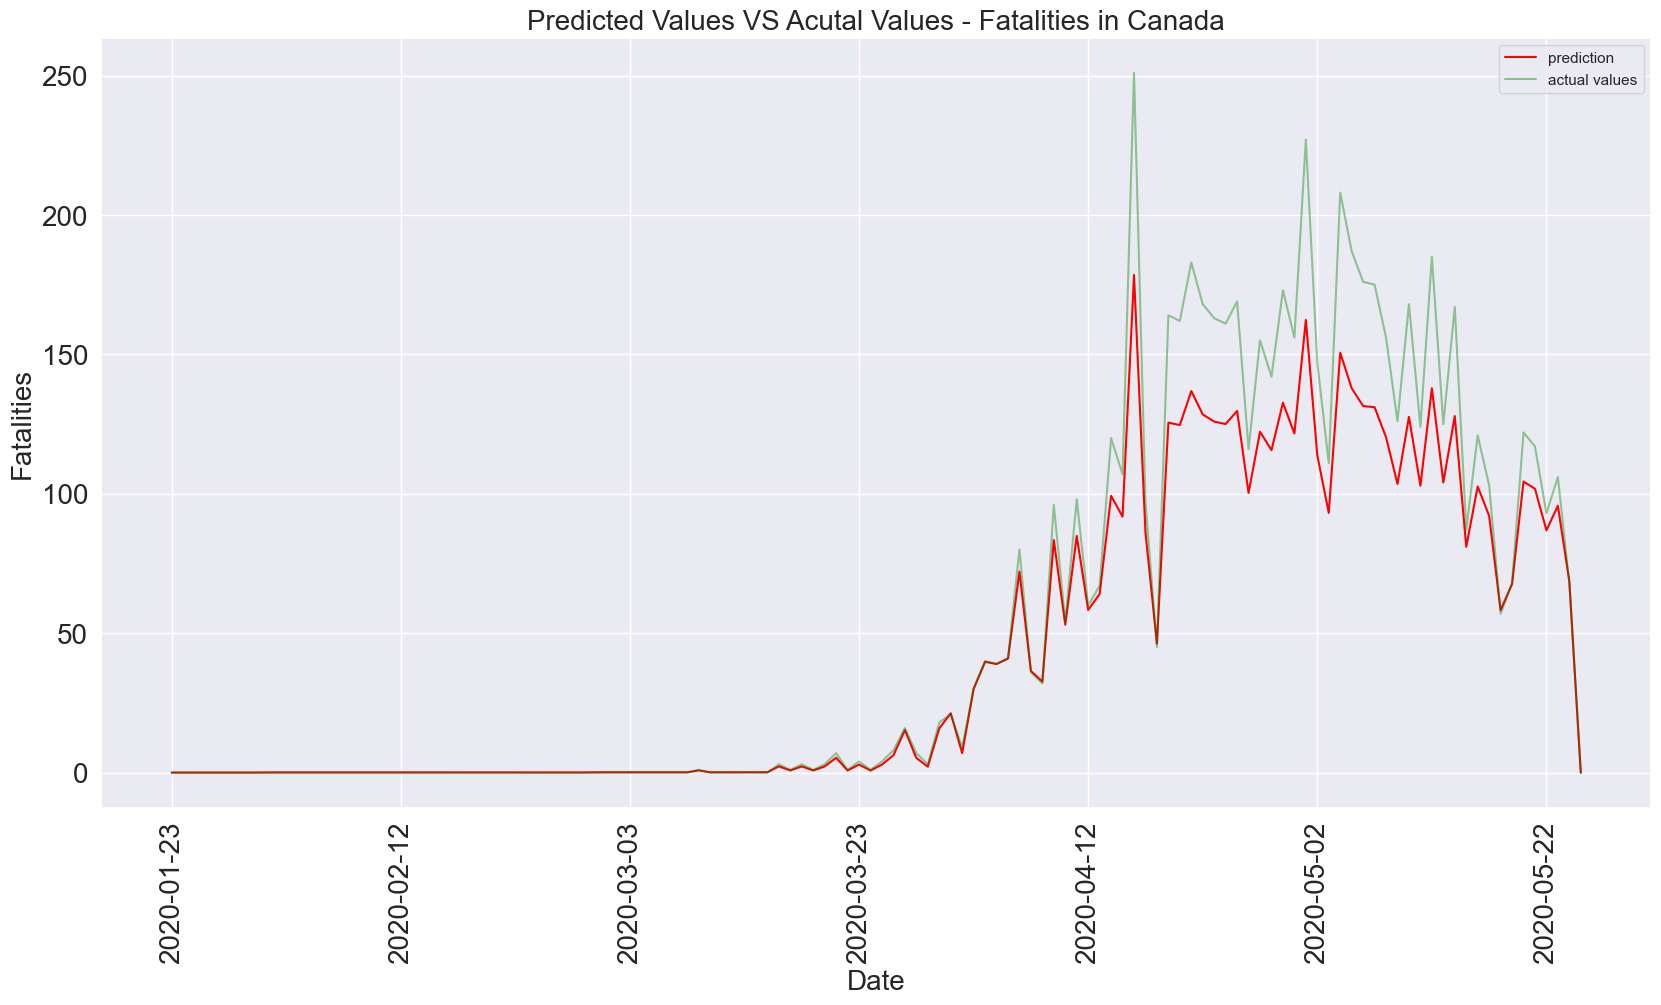

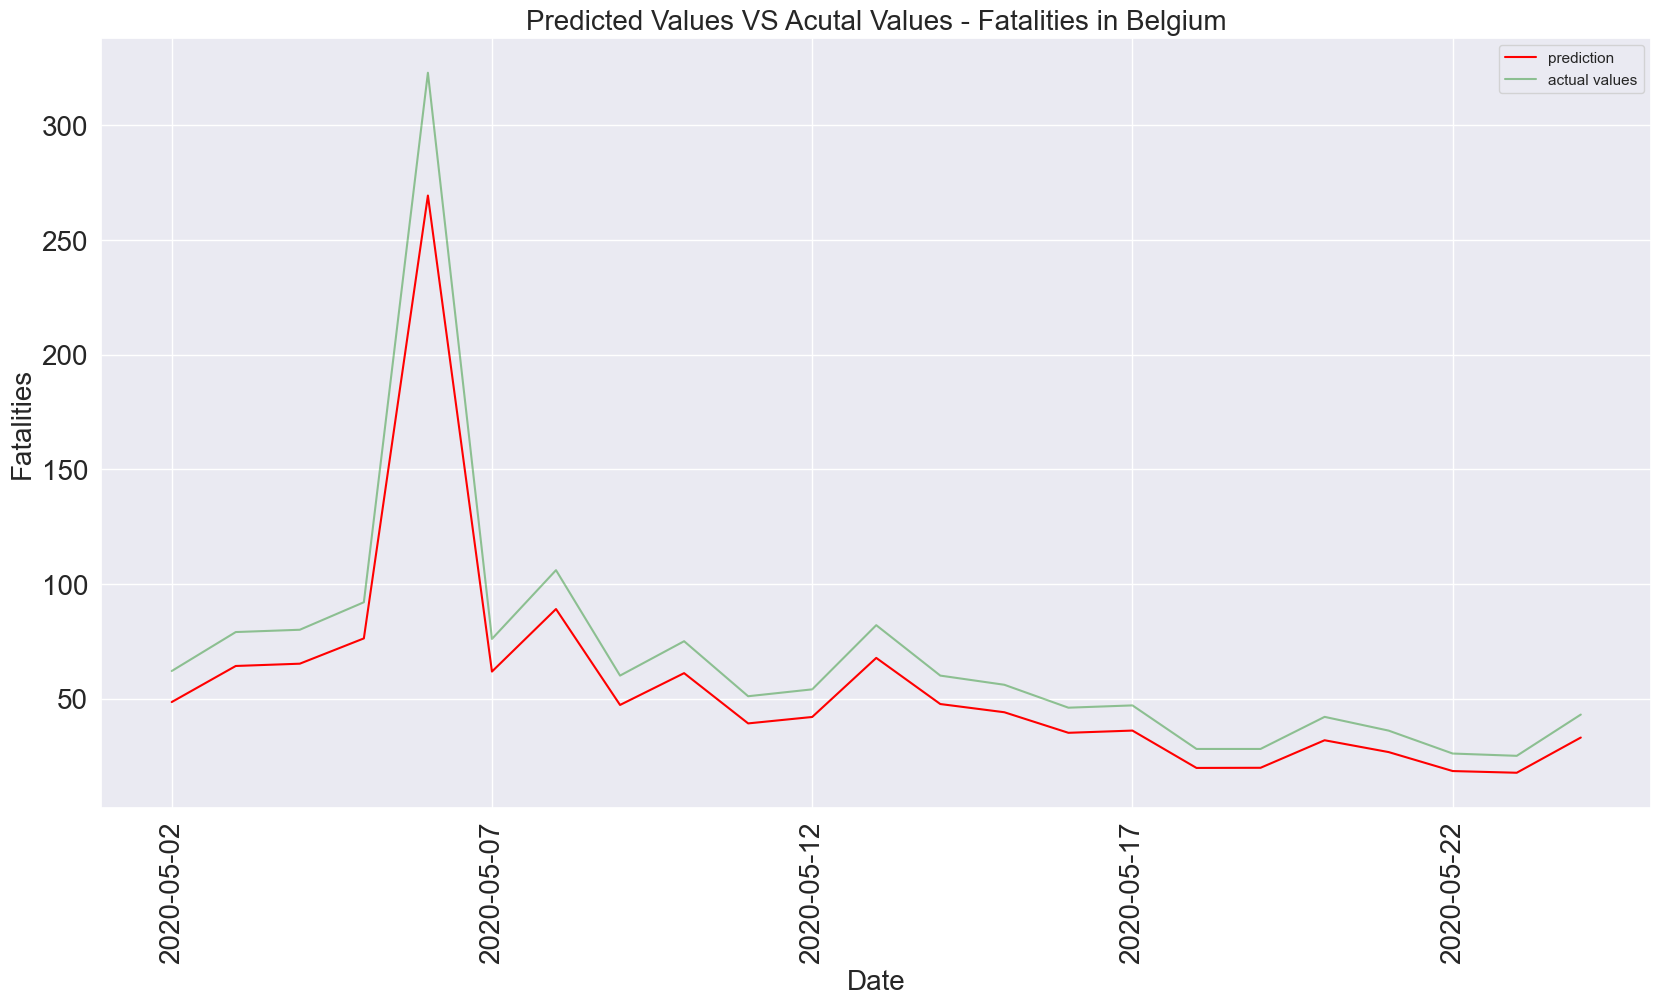

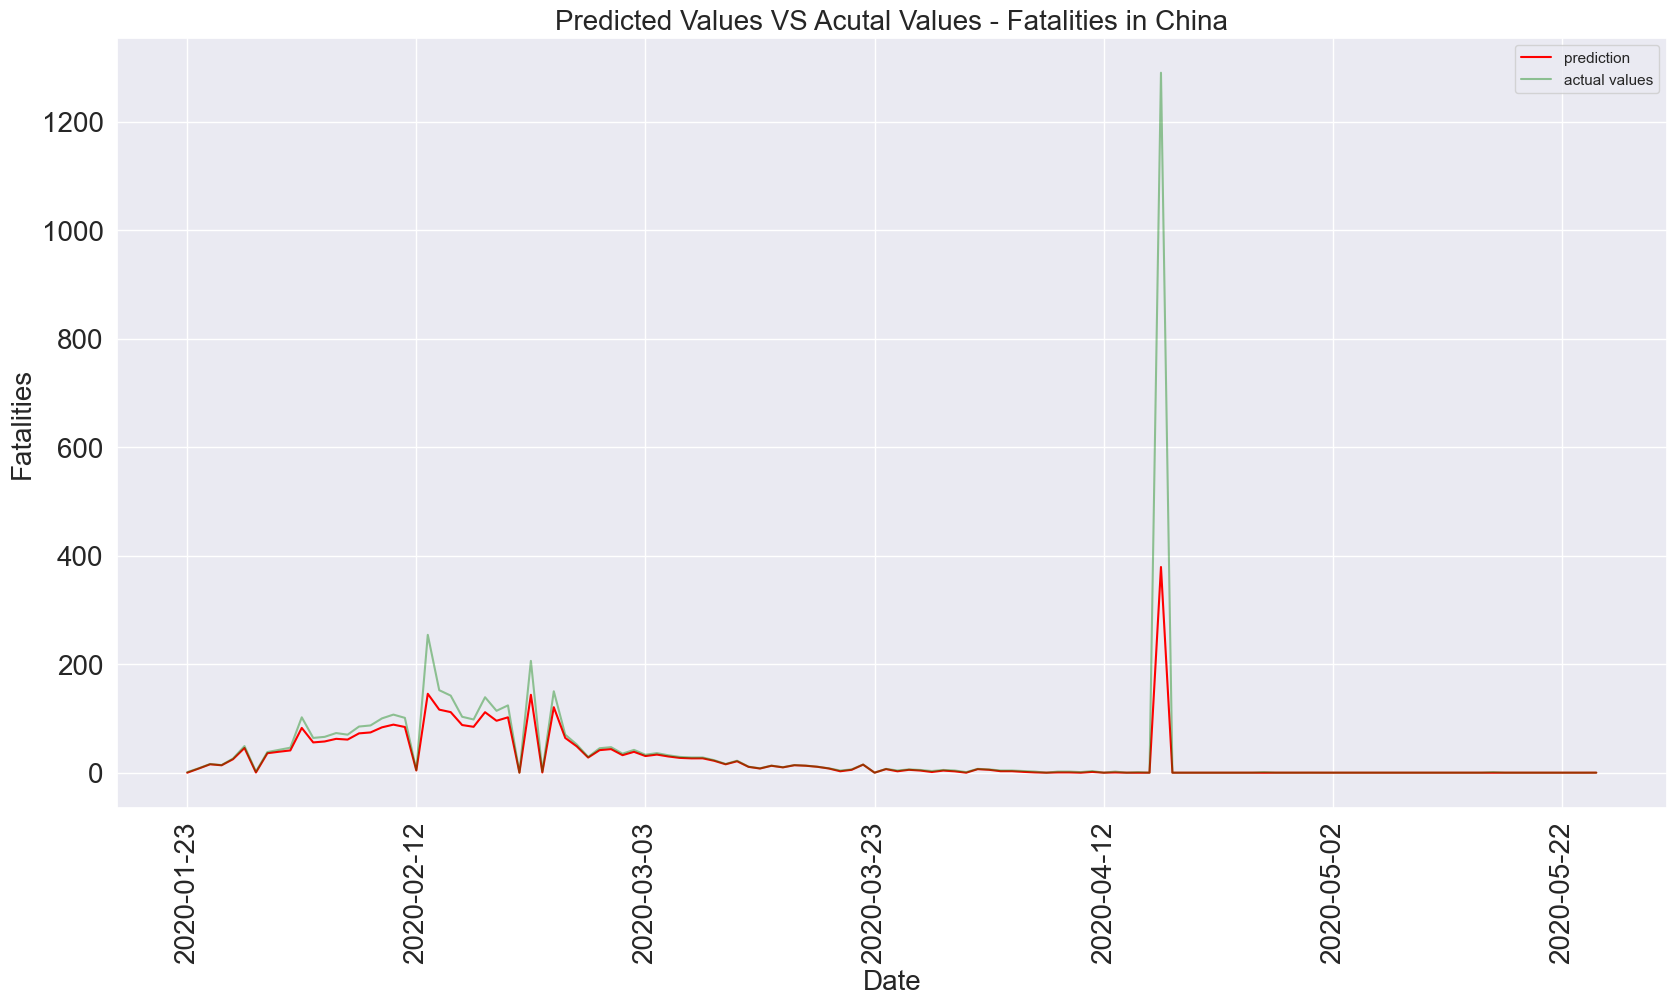

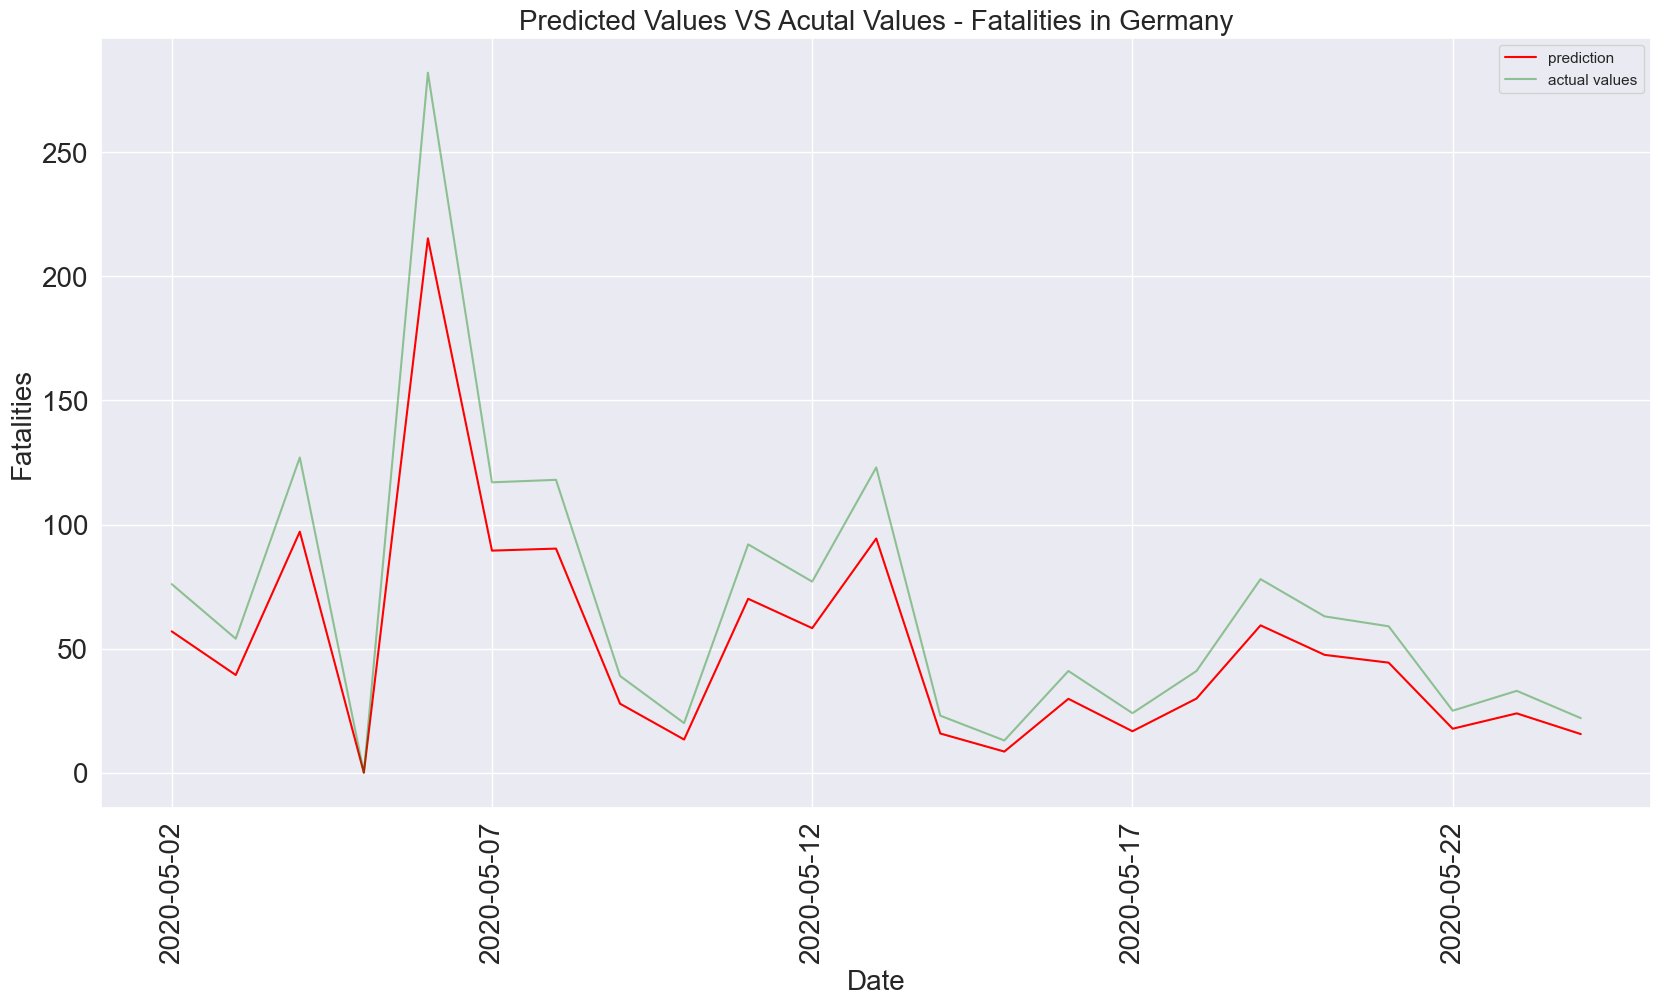

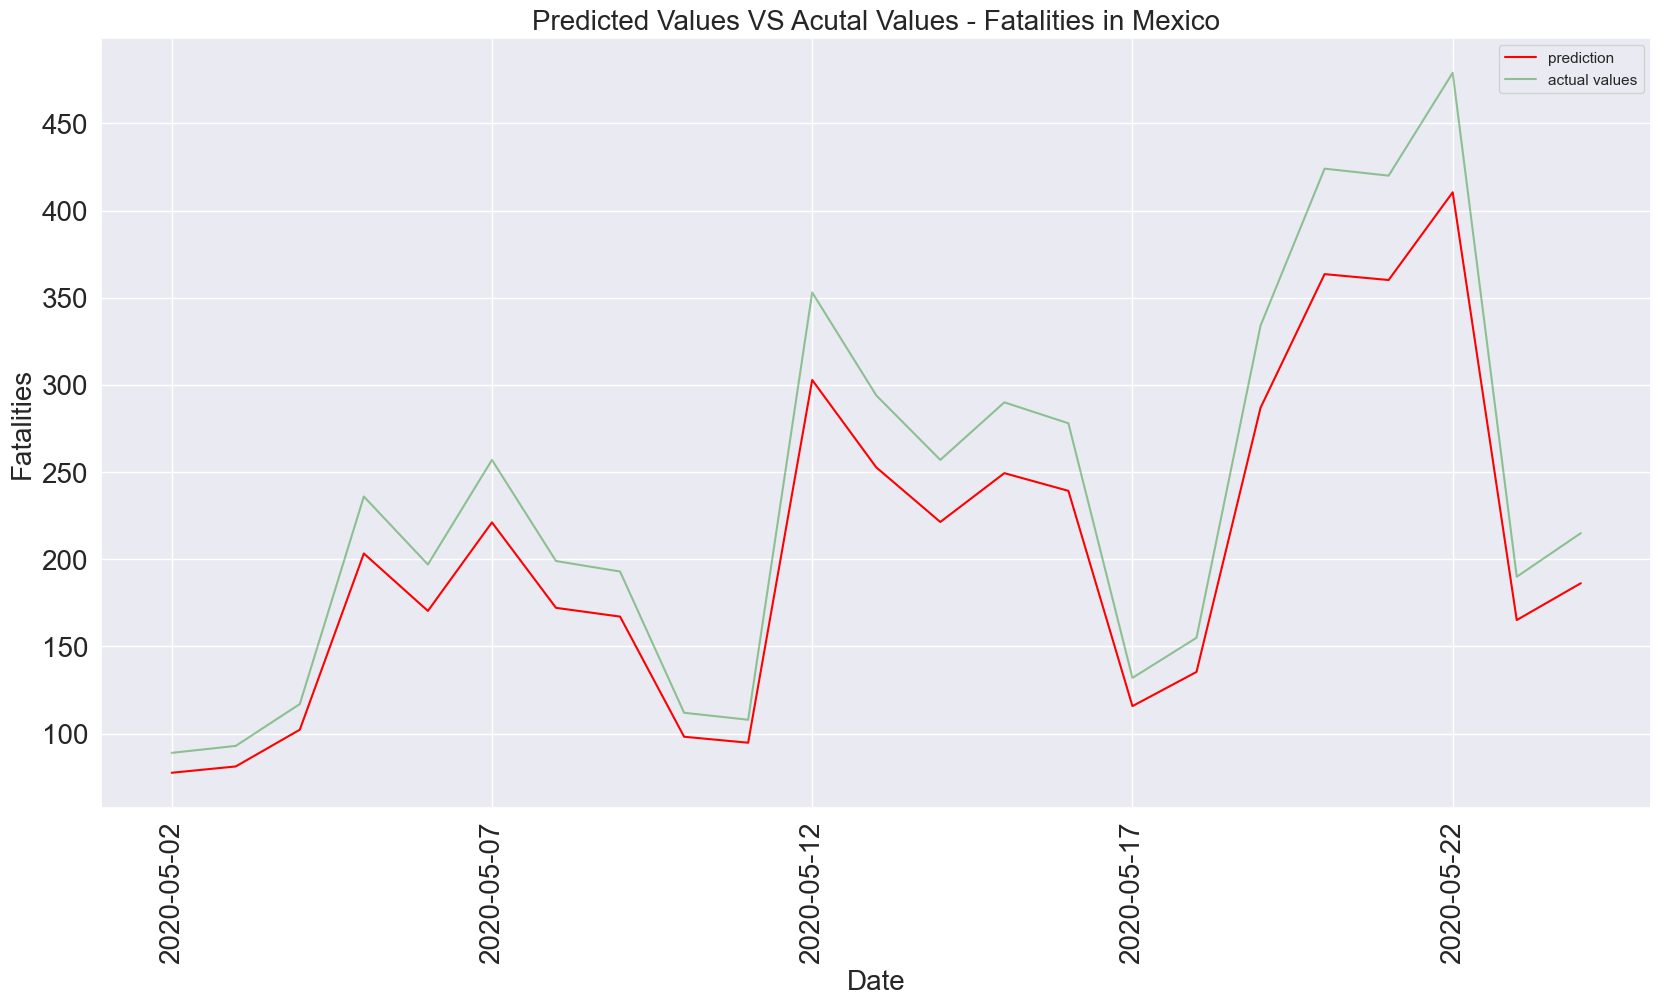

In [69]:
for i in range(len(top_10_country_names)): 
    country=fatality[fatality.Country_Region==top_10_country_names[i]]
    x_train, x_test,y_train,y_test=normalization_train_test_split(country)
    model = Sequential()
    model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(x_train, y_train, epochs=50, batch_size=30,  verbose=0, shuffle=False)
    y_test_pre=model.predict(x_test)
    
    rmse=RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:])
    print('{} - RMSE: {}'.format(top_10_country_names[i],rmse))
    
    pa=pd.DataFrame()
    pa['Date']=list(country.Date.iloc[int(len(country)*0.8):])[1:-1]
    pa['Prediction']=[i[0] for i in y_test_pre][1:] 
    pa['Actual Values']=list(y_test[:-1])

    plt.figure(figsize=(20,10))
    pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
    pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='green',alpha=0.4)
    plt.xticks(rotation=90,size=20)
    plt.yticks(size=20)

    plt.ylabel('Fatalities',fontsize=20)
    plt.xlabel('Date',fontsize=20)
    plt.title('Predicted Values VS Acutal Values - Fatalities in {}'.format(top_10_country_names[i]),fontsize=20)
    plt.legend()